# This script contains the ordered processing function
# Contents
## (S)PMI functions and visualization functions
## calculation including surrogate data, SPMI, and graph features
## Statistical analysis and visualization

## graph features to explore
- Node connectivity can be further explored such as between C3i-EMG
- asteroidal is ignored momentaneously, it will be a good idea to see shared asteroidal triples in the same condition.
- link analysis pay attention to every node


### graph analysis: similarity measure can be applied after a sub-graph is created

### Implementation: graph features and z-score analysis

### TMS effect: subj4/10 s02 vs subj4/10 s01
- mixed model: variables (circularity) - group effect (healthy, stroke) - ST-TMS effect (preTMS,postTMS)
- pre-post diff - TMS effect (sham/TMS)
- Linear model (corr): variables - rehabilitation duration/stroke scale

- random surrogate (test)
- save variables


## S1: (S)PMI functions

In [1]:
''' This module has essential functions supporting
fast and effective computation of permutation entropy and 
its different variations.'''
# original work: srk-srinivasan
# extension Gansheng_Tan
import itertools
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean


def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def s_entropy_withP(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    n_zeros = np.count_nonzero(freq_list==0)
    sh_entropy = n_zeros/len(freq_list)
    freq_list = [element for element in freq_list if element != 0]
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def p_entropy_withP(op):
    ''' Different from P_entropy: the max_entropy is calculated using the len(non_zero(op))
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    # op: ordinal pattern
#     ordinal_pat_nonzero = [element for element in op if element != 0]
#     max_entropy = np.log(len(ordinal_pat_nonzero))
#     p = np.divide(np.array(ordinal_pat_nonzero), float(sum(ordinal_pat_nonzero)))
#     return(s_entropy(p)/max_entropy)
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy_withP(p)/max_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    time_series = ts
    possible_permutations = list(itertools.permutations(range(embdim)))
    lst = list()
    for i in range(len(time_series) - embdelay * (embdim - 1)):
        sorted_index_array = list(np.argsort(time_series[i:(embdim+i)]))
        lst.append(sorted_index_array)
    lst = np.array(lst)
    element, freq = np.unique(lst, return_counts = True, axis = 0)
    freq = list(freq)
    if len(freq) != len(possible_permutations):
        for i in range(len(possible_permutations)-len(freq)):
            freq.append(0)
        return(freq)
    else:
        return(freq)

def p_entropy(op):
    # op: ordinal pattern
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    # take care of the variance within a observed pattern
    time_series = ts
    possible_permutations = list(itertools.permutations(range(embdim)))
    temp_list = list()
    wop = list()
    for i in range(len(time_series) - embdelay * (embdim - 1)):
        Xi = time_series[i:(embdim+i)]
        Xn = time_series[(i+embdim-1): (i+embdim+embdim-1)]
        Xi_mean = np.mean(Xi)
        Xi_var = (Xi-Xi_mean)**2
        weight = np.mean(Xi_var)
        sorted_index_array = list(np.argsort(Xi))
        temp_list.append([''.join(map(str, sorted_index_array)), weight])
    result = pd.DataFrame(temp_list,columns=['pattern','weights'])
    freqlst = dict(result['pattern'].value_counts())
    for pat in (result['pattern'].unique()):
        wop.append(np.sum(result.loc[result['pattern']==pat,'weights'].values))
    return(wop)

def joint_ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of two time series for a given embedding dimension and embedding delay.
    USAGE: joint_ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing two time series ,shape =(2,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    time_series_x = ts[0]
    time_series_y = ts[1]
    possible_permutations = list(itertools.permutations(range(embdim)))
    possible_permutations_repeat = np.repeat(np.array(list(itertools.permutations(range(embdim)))),6,axis=0)
    possible_permutations_interlace = np.array(list(itertools.permutations(range(embdim)))*6)
    possible_joint_permutations = np.concatenate((possible_permutations_repeat,possible_permutations_interlace),axis=1)
    lst_x = list()
    lst_y = list()
    lst = list()
    for i in range(len(time_series_x) - embdelay * (embdim - 1)):
        sorted_index_array = list(np.argsort(time_series_x[i:(embdim+i)]))
        lst_x.append(sorted_index_array)
        sorted_index_array = list(np.argsort(time_series_y[i:(embdim+i)]))
        lst_y.append(sorted_index_array)
    lst_x = np.array(lst_x)
    lst_y = np.array(lst_y)
    lst = np.concatenate ((lst_x,lst_y),axis=1)
    element, freq = np.unique(lst, return_counts = True, axis = 0)
    freq = list(freq)
    if len(freq) != len(possible_joint_permutations):
        for i in range(len(possible_joint_permutations)-len(freq)):
            freq.append(0)
        return(freq)
    else:
        return(freq)
    
def PMI_2chs(ts_2chs,embdim, embdelay):
    op_x = ordinal_patterns(ts_2chs[0],embdim,embdelay)
    op_y = ordinal_patterns(ts_2chs[1],embdim,embdelay)
    op_xy = joint_ordinal_patterns(ts_2chs,embdim,embdelay)
    p_x = p_entropy(op_x)
    p_y = p_entropy(op_y)
    p_xy = p_entropy(op_xy)
    return (p_x+p_y-p_xy)

def PMI_2chs_withP(ts_2chs,embdim, embdelay):
    op_x = ordinal_patterns(ts_2chs[0],embdim,embdelay)
    op_y = ordinal_patterns(ts_2chs[1],embdim,embdelay)
    op_xy = joint_ordinal_patterns(ts_2chs,embdim,embdelay)
    p_x = p_entropy_withP(op_x)
    p_y = p_entropy_withP(op_y)
    p_xy = p_entropy_withP(op_xy)
    return (p_x+p_y-p_xy)

def PMI_1epoch(epoch,embdim,embdelay):
    ''' This function computes the PMI for an epoch.
    USAGE: PMI_1epoch(epoch, embdim, embdelay)
    ARGS: epoch = Numpy arrayshape =(n_channels,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: PMI matrix
    '''
    PMI = np.zeros([epoch.shape[0],epoch.shape[0]])
    for i in range(epoch.shape[0]):
        for j in np.arange(i,epoch.shape[0]):
            op_x = ordinal_patterns(epoch[i],embdim,embdelay)
            op_y = ordinal_patterns(epoch[j],embdim,embdelay)
            op_xy = joint_ordinal_patterns(np.array([epoch[i],epoch[j]]),embdim,embdelay)
            p_x = p_entropy_withP(op_x)
            p_y = p_entropy_withP(op_y)
            p_xy = p_entropy_withP(op_xy)
            PMI[i,j] = (p_x+p_y-p_xy)
    return PMI

def PMI_epochs(epochs,embdim,embdelay):
    ''' This function computes the PMI for an epoch.
    USAGE: PMI_1epoch(epoch, embdim, embdelay)
    ARGS: epochs = Numpy arrayshape =(n_epochs,n_channels,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: PMI matrix
    '''
    PMI = np.zeros([epochs.shape[0],epochs.shape[1],epochs.shape[1]])
    for epoch_idx in range(epochs.shape[0]):
        for ch1_idx in range(epochs.shape[1]):
            for ch2_idx in np.arange(ch1_idx,epochs.shape[1]):
                op_x = ordinal_patterns(epochs[epoch_idx][ch1_idx],embdim,embdelay)
                op_y = ordinal_patterns(epochs[epoch_idx][ch2_idx],embdim,embdelay)
                op_xy = joint_ordinal_patterns(np.array([epochs[epoch_idx][ch1_idx],epochs[epoch_idx][ch2_idx]]),
                                               embdim,embdelay)
                p_x = p_entropy_withP(op_x)
                p_y = p_entropy_withP(op_y)
                p_xy = p_entropy_withP(op_xy)
                PMI[epoch_idx,ch1_idx,ch2_idx] = (p_x+p_y-p_xy)
    return PMI

def SPMI_2chs(ts_2chs,embdim, embdelay):
    op_x = ordinal_patterns(ts_2chs[0],embdim,embdelay)
    op_y = ordinal_patterns(ts_2chs[1],embdim,embdelay)
    op_xy = joint_ordinal_patterns(ts_2chs,embdim,embdelay)
    p_x = p_entropy(op_x)
    p_y = p_entropy(op_y)
    p_xy = p_entropy(op_xy)
    return (p_x+p_y-p_xy)/p_xy

def SPMI_1epoch(epoch,embdim,embdelay):
    ''' This function computes the SPMI for an epoch.
    USAGE: PMI_1epoch(epoch, embdim, embdelay)
    ARGS: epoch = Numpy arrayshape =(n_channels,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: PMI matrix
    '''
    SPMI = np.zeros([epoch.shape[0],epoch.shape[0]])
    for i in range(epoch.shape[0]):
        for j in np.arange(i,epoch.shape[0]):
            op_x = ordinal_patterns(epoch[i],embdim,embdelay)
            op_y = ordinal_patterns(epoch[j],embdim,embdelay)
            op_xy = joint_ordinal_patterns(np.array([epoch[i],epoch[j]]),embdim,embdelay)
            p_x = p_entropy_withP(op_x)
            p_y = p_entropy_withP(op_y)
            p_xy = p_entropy_withP(op_xy)
            SPMI[i,j] = (p_x+p_y-p_xy)/p_xy
    return SPMI

def SPMI_epochs(epochs,embdim,embdelay):
    ''' This function computes the SPMI for an epoch.
    USAGE: PMI_1epoch(epoch, embdim, embdelay)
    ARGS: epochs = Numpy arrayshape =(n_epochs,n_channels,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: assymmetric SPMI matrix
    '''
    SPMI = np.zeros([epochs.shape[0],epochs.shape[1],epochs.shape[1]])
    for epoch_idx in range(epochs.shape[0]):
        for ch1_idx in range(epochs.shape[1]):
            for ch2_idx in np.arange(ch1_idx,epochs.shape[1]):
                op_x = ordinal_patterns(epochs[epoch_idx][ch1_idx],embdim,embdelay)
                op_y = ordinal_patterns(epochs[epoch_idx][ch2_idx],embdim,embdelay)
                op_xy = joint_ordinal_patterns(np.array([epochs[epoch_idx][ch1_idx],epochs[epoch_idx][ch2_idx]]),
                                               embdim,embdelay)
                p_x = p_entropy_withP(op_x)
                p_y = p_entropy_withP(op_y)
                p_xy = p_entropy_withP(op_xy)
                SPMI[epoch_idx,ch1_idx,ch2_idx] = (p_x+p_y-p_xy)/p_xy
    return SPMI

def get_ch_name(epochs,ch_idx,emg_map=None):
    '''
    This function works when the number of EEG electrode is 32.
    if the emg mapping was given, the function return the muscle related to the emg electrod. 
    '''
    if ch_idx<32:
        return (epochs.info['ch_names'][ch_idx])
    elif ch_idx<40:
        if emg_map == None:
            return ('emg'+str(ch_idx-31))
        else:
            return emg_map['emg'+str(ch_idx-31)]
    else:
        return 0

def is_symmetric(a,tol = 1e-3):
    return (np.abs(a - a.T) <= tol).all()    
    
def chs_remap(cons,chs_list,pareticSide):
    '''
    This function is designed for hemisphere normalization for stroke patients. It remaps EEG electrodes into chs of 
    ipsilateral hemisphere and contralateral hemisphere
    
    Fpz,AFz,Fz,FCz,Cz,CPz,Pz,POz,Oz remains unmapped
    
    the cons is supposed to be a n * n matrix (symmetric or not), if cons is not symmetric, only the upper triangle is
    taken into account
    chs_list is passed by epochs_hybrid.info['ch_names']
    pareticSide can be only 'l' or 'r'
    '''
    if is_symmetric(cons) == False:
        cons =  cons + cons.T - np.diag(np.diag(cons))
    chs_map_lParetic = {'Fp1':'Fp1i','AF3':'AF3i','F3':'F3i','F7':'F7i','FC1':'FC1i','FC5':'FC5i','C3':'C3i',
                        'T7':'T7i','CP1':'CP1i','CP5':'CP5i','P3':'P3i','P7':'P7i','PO3':'PO3i','O1':'O1i',
                       'Fp2':'Fp1c','AF4':'AF3c','F4':'F3c','F8':'F7c','FC2':'FC1c','FC6':'FC5c','C4':'C3c',
                       'T8':'T8c','CP2':'CP1c','CP6':'CP5c','P4':'P3c','P8':'P7c','PO4':'PO3c','O2':'O1c'}
    
    chs_map_rParetic = {'Fp2':'Fp1i','AF4':'AF3i','F4':'F3i','F8':'F7i','FC2':'FC1i','FC6':'FC5i','C4':'C3i',
                        'T8':'T7i','CP2':'CP1i','CP6':'CP5i','P4':'P3i','P8':'P7i','PO4':'PO3i','O2':'O1i',
                       'Fp1':'Fp1c','AF3':'AF3c','F3':'F3c','F7':'F7c','FC1':'FC1c','FC5':'FC5c','C3':'C3c',
                       'T7':'T8c','CP1':'CP1c','CP5':'CP5c','P3':'P3c','P7':'P7c','PO3':'PO3c','O1':'O1c'}
    
    chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
    chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                                  'Fz','Cz','Pz','Oz',
                       'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                                 'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
    chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                                  'Fz','Cz','Pz','Oz',
                       'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                                 'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
 
    cons_remapped = np.zeros(cons.shape)
    if pareticSide == 'l':
        for ch1_idx in range(len(chs_list_image)):
            for ch2_idx in range(len(chs_list_image)):
                ch1_idx_preImage = chs_list.index(chs_list_preImage_lParetic[ch1_idx])
                ch2_idx_preImage = chs_list.index(chs_list_preImage_lParetic[ch2_idx])
                cons_remapped[ch1_idx,ch2_idx] = cons [ch1_idx_preImage,ch2_idx_preImage]
    elif pareticSide == 'r':
        for ch1_idx in range(len(chs_list_image)):
            for ch2_idx in range(len(chs_list_image)):
                ch1_idx_preImage = chs_list.index(chs_list_preImage_rParetic[ch1_idx])
                ch2_idx_preImage = chs_list.index(chs_list_preImage_rParetic[ch2_idx])
                cons_remapped[ch1_idx,ch2_idx] = cons [ch1_idx_preImage,ch2_idx_preImage]
        
    else:
        print("unknown pareticSide")
    return cons_remapped

def chs_remap4directionalCons(cons,chs_list,pareticSide):
    '''
    This function is designed for hemisphere normalization for stroke patients. It remaps EEG electrodes into chs of 
    ipsilateral hemisphere and contralateral hemisphere
    
    Fpz,AFz,Fz,FCz,Cz,CPz,Pz,POz,Oz remains unmapped
    
    the cons is supposed to be a n * n matrix (symmetric or not), if cons is not symmetric, only the upper triangle is
    taken into account
    chs_list is passed by epochs_hybrid.info['ch_names']
    pareticSide can be only 'l' or 'r'
    '''
    if is_symmetric(cons) == True:
        print("please make sure that the connectivity measure is directional")
    chs_map_lParetic = {'Fp1':'Fp1i','AF3':'AF3i','F3':'F3i','F7':'F7i','FC1':'FC1i','FC5':'FC5i','C3':'C3i',
                        'T7':'T7i','CP1':'CP1i','CP5':'CP5i','P3':'P3i','P7':'P7i','PO3':'PO3i','O1':'O1i',
                       'Fp2':'Fp1c','AF4':'AF3c','F4':'F3c','F8':'F7c','FC2':'FC1c','FC6':'FC5c','C4':'C3c',
                       'T8':'T8c','CP2':'CP1c','CP6':'CP5c','P4':'P3c','P8':'P7c','PO4':'PO3c','O2':'O1c'}
    
    chs_map_rParetic = {'Fp2':'Fp1i','AF4':'AF3i','F4':'F3i','F8':'F7i','FC2':'FC1i','FC6':'FC5i','C4':'C3i',
                        'T8':'T7i','CP2':'CP1i','CP6':'CP5i','P4':'P3i','P8':'P7i','PO4':'PO3i','O2':'O1i',
                       'Fp1':'Fp1c','AF3':'AF3c','F3':'F3c','F7':'F7c','FC1':'FC1c','FC5':'FC5c','C3':'C3c',
                       'T7':'T8c','CP1':'CP1c','CP5':'CP5c','P3':'P3c','P7':'P7c','PO3':'PO3c','O1':'O1c'}
    
    chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
    chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                                  'Fz','Cz','Pz','Oz',
                       'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                                 'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
    chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                                  'Fz','Cz','Pz','Oz',
                       'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                                 'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
 
    cons_remapped = np.zeros(cons.shape)
    if pareticSide == 'l':
        for ch1_idx in range(len(chs_list_image)):
            for ch2_idx in range(len(chs_list_image)):
                ch1_idx_preImage = chs_list.index(chs_list_preImage_lParetic[ch1_idx])
                ch2_idx_preImage = chs_list.index(chs_list_preImage_lParetic[ch2_idx])
                cons_remapped[ch1_idx,ch2_idx] = cons [ch1_idx_preImage,ch2_idx_preImage]
    elif pareticSide == 'r':
        for ch1_idx in range(len(chs_list_image)):
            for ch2_idx in range(len(chs_list_image)):
                ch1_idx_preImage = chs_list.index(chs_list_preImage_rParetic[ch1_idx])
                ch2_idx_preImage = chs_list.index(chs_list_preImage_rParetic[ch2_idx])
                cons_remapped[ch1_idx,ch2_idx] = cons [ch1_idx_preImage,ch2_idx_preImage]
        
    else:
        print("unknown pareticSide")
    return cons_remapped
       

## S2: Visualization fcs

In [2]:
from itertools import count
import matplotlib,numpy as np
import matplotlib.cm as cm

class EEGChannel:
    '''innitilized by info chs'''
    _ids = count(0)
    
    def __init__(self, x, y,name="None"):
        self.id = next(self._ids)
        self.x = x
        self.y = y
        self.name = name
    def plot(self,ax,center):
        circle = plt.Circle((center[0]+self.x, center[1]+self.y), radius=0.2,fill = True)
        ax.add_patch(circle)
        label = ax.annotate(self.name, xy=(center[0]+self.x, center[1]+self.y), fontsize=18, ha="center")
        return ax 

    
class EMGChannel:
    '''with polar coordinates as inputs'''
    
    _ids = count(0)
    
    def __init__(self, rho, phi,name="None"):
        self.id = next(self._ids)
        self.rho = rho
        self.phi = phi
        self.name = name
        self.x = rho * np.cos(phi/180*np.pi)
        self.y = rho * np.sin(phi/180*np.pi)
        
    def plot(self,ax,center):
        circle = plt.Circle((center[0]+self.x, center[1]+self.y), radius=0.2,fill = True)
        ax.add_patch(circle)
        label = ax.annotate(self.name, xy=(center[0]+self.x, center[1]+self.y), fontsize=18, ha="center")
        return ax        
    
    def cartesianC(self):
        return(self.x, self.y)
    
    def polarC(self):
        return(self.rho,self.phi)

# EMG Topograph_basis
def plotTopoEMG(EMGs,ax,center=[7,0]):
    for i in range(2):
        circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
        ax.add_artist(circle)
    for EMG in EMGs:
        ax = EMG.plot(ax,center)
    return ax

def plotTopoEEG(EEGs,ax,center=[-5,0],radius=6):
    circle = plt.Circle((center[0],center[1]),radius,fill = False)
    ax.plot()
    ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
    ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
    ax.add_artist(circle)
    for EEG in EEGs:
        ax = EEG.plot(ax,center)
    return ax    
    
def c_map(data):
    '''
    data should be numpy array (adj_m, for example)
    '''
    minima = np.min(data[np.nonzero(data)])
    maxima = np.max(data)
    if minima==maxima:
        minima-=0.2
        maxima+=0.2
    norm = matplotlib.colors.Normalize(vmin=minima,vmax=maxima,clip=True)
#     mapper = cm.ScalarMappable(norm=norm,cmap=cm.viridis)
    mapper = cm.ScalarMappable(norm=norm,cmap="bwr")
    return mapper

def c_map_bwr(data):
    '''
    data should be numpy array (adj_m, for example)
    '''
    minima = np.min(data[np.nonzero(data)])
    maxima = np.max(data)
    if minima==maxima:
        minima-=0.2
        maxima+=0.2
    boundary = (np.abs(maxima)+np.abs(minima))/2
    norm = matplotlib.colors.Normalize(vmin=-boundary,vmax=boundary,clip=True)
#     mapper = cm.ScalarMappable(norm=norm,cmap=cm.viridis)
    mapper = cm.ScalarMappable(norm=norm,cmap="bwr")
    return mapper

def graph_plot(adj_m,fig,ax,ignore_zero=True,center_EEG=[-5,0],center_EMG=[7,0]):
    mapper = c_map(adj_m)
    if ignore_zero==True:
        for ix,iy in np.ndindex(adj_m.shape):
            if -0.1<adj_m[ix,iy]<0.1:
                pass
            else:
                if ix>31:
                    if iy>31:
                        ax.plot([EMGs[ix-32].x+center_EMG[0], EMGs[iy-32].x+center_EMG[0]],
                                [EMGs[ix-32].y+center_EMG[1], EMGs[iy-32].y+center_EMG[1]],
                                color = mapper.to_rgba(adj_m[ix,iy]))
                    else:
                        ax.plot([EMGs[ix-32].x+center_EMG[0], EEGs[iy].x+center_EEG[0]],
                                [EMGs[ix-32].y+center_EMG[1], EEGs[iy].y+center_EEG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
                else:
                    if iy>31:
                        ax.plot([EEGs[ix].x+center_EEG[0], EMGs[iy-32].x+center_EMG[0]],
                                [EEGs[ix].y+center_EEG[1], EMGs[iy-32].y+center_EMG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
                    else:
                        ax.plot([EEGs[ix].x+center_EEG[0], EEGs[iy].x+center_EEG[0]],
                                [EEGs[ix].y+center_EEG[1], EEGs[iy].y+center_EEG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
    fig.colorbar(mapper,ax=ax)
    return fig,ax

def graph_plot_fixMapper(adj_m,adj_m_fix,fig,ax,ignore_zero=True,center_EEG=[-5,0],center_EMG=[7,0]):
    mapper = c_map_bwr(adj_m_fix)
    if ignore_zero==True:
        for ix,iy in np.ndindex(adj_m.shape):
            if -0.1<adj_m[ix,iy]<0.1:
                pass
            else:
                if ix>31:
                    if iy>31:
                        ax.plot([EMGs[ix-32].x+center_EMG[0], EMGs[iy-32].x+center_EMG[0]],
                                [EMGs[ix-32].y+center_EMG[1], EMGs[iy-32].y+center_EMG[1]],
                                color = mapper.to_rgba(adj_m[ix,iy]))
                    else:
                        ax.plot([EMGs[ix-32].x+center_EMG[0], EEGs[iy].x+center_EEG[0]],
                                [EMGs[ix-32].y+center_EMG[1], EEGs[iy].y+center_EEG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
                else:
                    if iy>31:
                        ax.plot([EEGs[ix].x+center_EEG[0], EMGs[iy-32].x+center_EMG[0]],
                                [EEGs[ix].y+center_EEG[1], EMGs[iy-32].y+center_EMG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
                    else:
                        ax.plot([EEGs[ix].x+center_EEG[0], EEGs[iy].x+center_EEG[0]],
                                [EEGs[ix].y+center_EEG[1], EEGs[iy].y+center_EEG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
    fig.colorbar(mapper,ax=ax)
    return fig,ax



# Calculation
## step 1: dataset loading - run till here to begin further analyses

In [11]:
########## Import ##############
import os,numpy as np, pandas as pd,mne
################################

################## Dataset Loading ##################
data_dir = 'D:/Data/MultiEEGEMG_stroke/'
# data_dir = 'E:/important file/Projects/CM-graph/sample_data' #PC dir
subj_idx = '35'
contraction_type = 'iMC'
session_idx = 's02'

subjInfo_fName = os.path.join(data_dir,'subj_info.txt')
subjInfo = pd.read_csv(subjInfo_fName, skiprows=0,
                       sep = ',',engine = 'python')
affected_h = subjInfo[subjInfo['subj_idx']==int(subj_idx)]['affected_h'].values[0]

results_dir = os.path.join(data_dir,'subj'+subj_idx,'results')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

epochs_hybrid_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid')
epochs_hybrid_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_hybrid_epo.fif')
epochs_hybrid = mne.read_epochs(epochs_hybrid_fName,preload=True)
#####################################################################

Reading D:/Data/MultiEEGEMG_stroke/subj35\epochs_hybrid\subj35_iMC_s02_hybrid_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
43 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


## Step 2: baseline surrogate (bsrg) generation

In [466]:
import os
##### Parameters
embdim = 3
embdelay = 1
step = 50
num_srg = 100
epoch_duration_sample = 1001
##################################
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
#################
# load baseline raw
raw_srg_dir = os.path.join(data_dir,'subj'+subj_idx,'raw_srg')
raw_srg_fName = os.path.join(raw_srg_dir,'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_srg_raw.fif')
raw_srg = mne.io.read_raw_fif(raw_srg_fName)

SPMI_bsrg_dstbts = np.zeros((epochs_hybrid.get_data().shape[1],epochs_hybrid.get_data().shape[1],num_srg))
for ch1_idx in range(epochs_hybrid.get_data().shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,epochs_hybrid.get_data().shape[1]):
        SPMI_srg_dstbt_2chs = []
        if affected_h == 'l':
            ch2_idx_preImage = epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[ch2_idx])
            ch1_idx_preImage = epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[ch1_idx])
        elif affected_h == 'r':
            ch2_idx_preImage = epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[ch2_idx])
            ch1_idx_preImage = epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[ch1_idx])
        else:
             print('unknown EEG ch')
        for i in range(num_srg):
            ch1_srg_data = raw_srg.get_data()[ch1_idx_preImage][i*step:epoch_duration_sample+i*step]
            ch2_srg_data = raw_srg.get_data()[ch2_idx_preImage][i*step:epoch_duration_sample+i*step]
            SPMI_srg_dstbt_2chs.append(SPMI_2chs([ch1_srg_data,ch2_srg_data],embdim,embdelay))
        SPMI_bsrg_dstbts[ch1_idx][ch2_idx] = SPMI_srg_dstbt_2chs

Opening raw data file D:/Data/MultiEEGEMG_stroke/subj35\raw_srg\subj35_iMC_s02_srg_raw.fif...
    Range : 1275 ... 11275 =      2.550 ...    22.550 secs
Ready.


## Step 3: bsrg saving

In [467]:
import numpy as np
from numpy import savetxt
temp_dir = os.path.join(data_dir,'subj'+subj_idx,'temp')
SPMI_bsrg_dstbts_fName = os.path.join(temp_dir,contraction_type+'_'+session_idx+'_SPMI_bsrg.txt')
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)
with open(SPMI_bsrg_dstbts_fName, 'w') as outfile:
    outfile.write('# Array shape: {0}\n'.format(SPMI_bsrg_dstbts.shape))
    for data_slice in SPMI_bsrg_dstbts:
        np.savetxt(outfile, data_slice, fmt='%-7.4f')
        outfile.write('# New slice\n')

## Step 4: SPMI calculation

In [468]:
######## import #########
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#########################

########## Customization ##########
alpha = 0.05
embdim = 3
embdelay = 1
# ho stands for homogeneous

###################################
epoch_data = epochs_hybrid.get_data()
SPMI = SPMI_epochs(epoch_data,embdim,embdelay)

for SPMI_idx in range(SPMI.shape[0]):
    SPMI[SPMI_idx] = chs_remap(SPMI[SPMI_idx],epochs_hybrid.info['ch_names'],affected_h)

SPMI_withoutD = SPMI.copy()
for SPMI_idx in range(SPMI_withoutD.shape[0]):
    SPMI_withoutD[SPMI_idx] = SPMI_withoutD[SPMI_idx] - np.diag(np.diag(SPMI_withoutD[SPMI_idx]))
# SPMI_withoutD_overall_m = np.sum(SPMI_withoutD)/np.count_nonzero(SPMI_withoutD)

## Step 5: SPMI saving

In [469]:
import numpy as np
from numpy import savetxt
temp_dir = os.path.join(data_dir,'subj'+subj_idx,'temp')
SPMI_fName = os.path.join(temp_dir,contraction_type+'_'+session_idx+'_SPMI.txt')
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)
with open(SPMI_fName, 'w') as outfile:
    outfile.write('# Array shape: {0}\n'.format(SPMI_withoutD.shape))
    for data_slice in SPMI_withoutD:
        np.savetxt(outfile, data_slice, fmt='%-7.4f')
        outfile.write('# New slice\n')

## Step 6: graph generation
- one-tailed (higher) ind t-test to spot significant connection (alpha=1e-3)
- z-normalization

In [470]:
######## import #########
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# ########################distribution check - Normal
# import matplotlib.pyplot as plt
# plt.hist(SPMI_withoutD[:,0,7])
# #############

########## Customization ##########
alpha = 1e-3
embdim = 3
embdelay = 1
n_chs_eeg = 32
n_chs_emg = 8
# he stands for homogeneous

t_stats = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
p_values = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
sig_cons_mask = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
SPMI_withoutD_zth = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
for ch1_idx in range(SPMI_withoutD.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_withoutD.shape[2]):
        SPMI_2chs_dstbt = SPMI_withoutD[:,ch1_idx,ch2_idx]
        SPMI_2chs_bsrg_dstbt = SPMI_bsrg_dstbts[ch1_idx,ch2_idx,:] 
        t_stat,p_value = stats.ttest_ind(SPMI_2chs_dstbt,SPMI_2chs_bsrg_dstbt)
        t_stats[ch1_idx][ch2_idx] = t_stat
        p_values[ch1_idx][ch2_idx] = p_value
        if t_stat > 0 and p_value/2<alpha:
            sig_cons_mask[ch1_idx][ch2_idx] = True
            SPMI_withoutD_zth[ch1_idx][ch2_idx] = (np.mean(SPMI_2chs_dstbt) - np.mean(SPMI_2chs_bsrg_dstbt))/np.std(SPMI_2chs_bsrg_dstbt)
SPMI_withoutD_zth = SPMI_withoutD_zth* sig_cons_mask


## Step 7: save SPMI_zth

In [471]:
import numpy as np
temp_dir = os.path.join(data_dir,'subj'+subj_idx,'temp')
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)
SPMI_withoutD_zth_fName = os.path.join(temp_dir,contraction_type+'_'+session_idx+'_zth_meanSPMI')
np.save(SPMI_withoutD_zth_fName,SPMI_withoutD_zth)

## Step 8: graph features extraction and saving
- including non_connected graph transformation

In [52]:
import networkx as nx, numpy as np
from networkx.algorithms import smallworld as sw
from networkx.algorithms import wiener_index as wi
from networkx.algorithms import approximation as approx
import pandas as pd
from itertools import combinations, groupby
import random
from numpy import inf

temp_dir = os.path.join(data_dir,'subj'+subj_idx,'temp')
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)


G = nx.convert_matrix.from_numpy_matrix(SPMI_withoutD_zth+np.transpose(SPMI_withoutD_zth)) # symmetric adj

# case of non fully connected graph
if nx.is_connected(G) == False:
    components = dict(enumerate(nx.connected_components(G)))
    components_combs = combinations(components.keys(),r=2)
    for _, node_edges in groupby(components_combs,key=lambda x:x[0]):
        node_edges = list (node_edges)
        random_comps = random.choice(node_edges)
        source = random.choice(list(components[random_comps[0]]))
        target = random.choice(list(components[random_comps[1]]))
        G.add_edge(source,target,weight = 0.1)
    connected_components = list(components.values()) 
else:
    connected_components = 'connectedGraph'



radius = nx.radius(G)
diameter = nx.diameter(G)
shortestPath = dict(nx.shortest_path_length(G))
ecc=nx.eccentricity(G,sp=shortestPath)
shortestPath_weight = dict(nx.shortest_path_length(G,weight='weight'))
ecc_weight=nx.eccentricity(G,sp=shortestPath_weight)

center = nx.center(G)
density = nx.density(G)
sw_omega = sw.omega(G)
wiener_idx = wi(G)
wiener_idx_weight = wi(G,weight='weight')
node_connectivity_wholeG = approx.connectivity.node_connectivity(G)
# node_connectivity_wholeEEG2EMG = approx.connectivity.node_connectivity(G,s=np.arange(0,32),
#                                                                                             t=np.arange(32,40))
# lClique_size = approx.clique.large_clique_size(G)
mean_clusteringC = approx.clustering_coefficient.average_clustering(G)
max_indSet = approx.independent_set.maximum_independent_set(G)
assortativityCoefficient = nx.algorithms.assortativity.degree_assortativity_coefficient(G)
# asteroidalTriple = nx.algorithms.asteroidal.find_asteroidal_triple(G)
bridges = list(nx.bridges(G))
eigenvector_centrality = nx.eigenvector_centrality(G,weight='weight')
phi = max(nx.adjacency_spectrum(G))
# katz_centrality = nx.katz_centrality(G, 1 / phi - 0.01)
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G,weight='weight')
closeness_centrality = nx.closeness_centrality(G,distance='weight')

# group def
groups_centrality = {'group_ipsiH_centrality':[], 'group_contraH_centrality':[], 'group_forearm_centrality':[],
                     'group_arm_centrality':[],
                     'group_ipsiF_centrality':[], 'group_ipsiMotor_centrality':[], 'group_ipsiPO_centrality':[],
                     'group_mesial_centrality':[], 'group_contraF_centrality':[], 'group_contraMotor_centrality':[], 
                     'group_contraPO_centrality':[]}
groups = {'group_ipsiH_centrality':np.arange(14),'group_contraH_centrality':np.arange(18,32), 
          'group_forearm_centrality':np.arange(32,37), 'group_arm_centrality':np.arange(37,40),
          'group_ipsiF_centrality':np.arange(4), 'group_ipsiMotor_centrality':[4,5,6,8,9], 
          'group_ipsiPO_centrality':[10,11,12,13],'group_mesial_centrality':[14,15,16,17], 
          'group_contraF_centrality':[18,19,20,21], 'group_contraMotor_centrality':[22,23,24,26,27], 
                     'group_contraPO_centrality':[28,29,30,31]}
# betweenness->closeness->degree
for group_centrality in groups_centrality.keys():
    group = groups[group_centrality]
    groups_centrality[group_centrality] = [nx.group_betweenness_centrality(G,group,weight='weight'), 
                            nx.group_closeness_centrality(G,group,weight='weight'), nx.group_degree_centrality(G,group)]

g_cliqueNumber = nx.algorithms.clique.graph_clique_number(G)
g_numberOfMaxClique = nx.algorithms.clique.graph_number_of_cliques(G)
transitivity = nx.transitivity(G)
clusteringC_weight = nx.clustering(G,weight='weight')
local_efficiency = nx.algorithms.efficiency_measures.local_efficiency(G)
global_efficiency = nx.algorithms.efficiency_measures.global_efficiency(G)
isolates = list(nx.isolates(G))
try:
    nr, nr_rd = nx.non_randomness(G)
except:
    try:
        nr,nr_rd = nx.non_randomness(G,2)
    except:
        nr,nr_rd = nx.non_randomness(G,1)
rich_club_coefficient =  nx.rich_club_coefficient(G, normalized=False, seed=42)
average_shortestPathLength_weight = nx.average_shortest_path_length(G,weight='weight')
s_metric = nx.algorithms.smetric.s_metric(G,normalized=False)
closeness_vitality = nx.algorithms.vitality.closeness_vitality(G)
closeness_vitality_weight = nx.algorithms.vitality.closeness_vitality(G,weight='weight')
nodes_degree = list(G.degree(weight='weight'))
size = G.size()
size_weight = G.size(weight='weight')

# spanning tree
G_minST = nx.minimum_spanning_tree(G)
G_maxST = nx.maximum_spanning_tree(G)
wiener_idx_minST_weight = wi(G_minST,weight='weight')
wiener_idx_maxST_weight = wi(G_maxST,weight='weight')
size_minST_weight = G_minST.size(weight='weight')
size_maxST_weight = G_maxST.size(weight='weight')

# info transmission measure
cost = np.reciprocal(SPMI_withoutD_zth)
cost[cost==inf]=0
# cost = np.multiply(cost, ((SPMI_withoutD_zth+np.transpose(SPMI_withoutD_zth)) !=0))
G_cost = nx.convert_matrix.from_numpy_matrix(cost+np.transpose(cost)) # symmetric adj

#global indicators
cost_average_shortestP_length = nx.average_shortest_path_length(G_cost)
cost_average_shortestP_length_weight = nx.average_shortest_path_length(G_cost, weight = 'weight')
cost_wiener_index_weight = wi(G_cost,weight='weight')
cost_size_weight = G_cost.size(weight='weight')

cost_betweenness_centrality = nx.betweenness_centrality(G_cost,weight='weight')
cost_eigenvector_centrality = nx.eigenvector_centrality(G_cost,weight='weight')
cost_closeness_centrality = nx.closeness_centrality(G_cost,distance='weight')
cost_closeness_vitality_weight = nx.algorithms.vitality.closeness_vitality(G_cost,weight='weight')
shortestPath_weight = dict(nx.shortest_path_length(G_cost,weight='weight'))
cost_ecc_weight=nx.eccentricity(G_cost,sp=shortestPath_weight)

cost_groups_centrality = {'cost_group_ipsiH_centrality':[], 'cost_group_contraH_centrality':[], 
                          'cost_group_forearm_centrality':[],'cost_group_arm_centrality':[],
                         'cost_group_ipsiF_centrality':[], 'cost_group_ipsiMotor_centrality':[], 
                        'cost_group_ipsiPO_centrality':[],'cost_group_mesial_centrality':[], 
                          'cost_group_contraF_centrality':[], 'cost_group_contraMotor_centrality':[], 
                     'cost_group_contraPO_centrality':[]}
cost_groups = {'cost_group_ipsiH_centrality':np.arange(14),'cost_group_contraH_centrality':np.arange(18,32), 
          'cost_group_forearm_centrality':np.arange(32,37), 'cost_group_arm_centrality':np.arange(37,40),
          'cost_group_ipsiF_centrality':np.arange(4), 'cost_group_ipsiMotor_centrality':[4,5,6,8,9], 
          'cost_group_ipsiPO_centrality':[10,11,12,13],'cost_group_mesial_centrality':[14,15,16,17], 
          'cost_group_contraF_centrality':[18,19,20,21], 'cost_group_contraMotor_centrality':[22,23,24,26,27], 
                     'cost_group_contraPO_centrality':[28,29,30,31]}
for cost_group_centrality in cost_groups_centrality.keys():
    cost_group = cost_groups[cost_group_centrality]
    cost_groups_centrality[cost_group_centrality] = [nx.group_betweenness_centrality(G_cost,cost_group,weight='weight'), 
                            nx.group_closeness_centrality(G_cost,cost_group,weight='weight'), 
                                                     nx.group_degree_centrality(G_cost,cost_group)]

sources = [4,6,8,22,24,26]
cost_shortest_path =[]
cost_shortest_path_length = []
cost_shortest_path_weight = []
cost_shortest_path_length_weight = []
for ch in sources:
    cost_shortest_path.append(nx.shortest_path(G_cost,source =ch,target =32))
    cost_shortest_path_length.append(nx.shortest_path_length(G_cost,source =ch,target =32))
    cost_shortest_path_weight.append(nx.shortest_path(G_cost,source =ch,target =32,weight='weight'))
    cost_shortest_path_length_weight.append(nx.shortest_path_length(G_cost,source =ch,target =32,weight='weight'))


d = {'radius':[radius],'diameter':[diameter],'center':[center],'density':[density],'sw_omega':[sw_omega],
     'wiener_idx':[wiener_idx],'wiener_idx_weight':[wiener_idx_weight],
     'node_connectivity_wholeG':[node_connectivity_wholeG],
     'mean_clusteringC':[mean_clusteringC],'max_indSet':[max_indSet],
     'assortativityCoefficient':[assortativityCoefficient],'bridges':[bridges],
#      'katz_centrality':[katz_centrality],
     'eigenvector_centrality':[cost_eigenvector_centrality],'closeness_centrality':[closeness_centrality],
     'degree_centrality':[degree_centrality], 'betweenness_centrality':[betweenness_centrality],
    'group_ipsiH_centrality':[groups_centrality['group_ipsiH_centrality']], 
     'group_contraH_centrality':[groups_centrality['group_contraH_centrality']],
     'group_forearm_centrality':[groups_centrality['group_forearm_centrality']],
     'group_arm_centrality':[groups_centrality['group_arm_centrality']],
     'group_ipsiF_centrality':[groups_centrality['group_ipsiF_centrality']],
     'group_ipsiMotor_centrality':[groups_centrality['group_ipsiMotor_centrality']],
     'group_ipsiPO_centrality':[groups_centrality['group_ipsiPO_centrality']],
     'group_mesial_centrality':[groups_centrality['group_mesial_centrality']],
     'group_contraF_centrality':[groups_centrality['group_contraF_centrality']],
     'group_contraMotor_centrality':[groups_centrality['group_contraMotor_centrality']],
     'group_contraPO_centrality':[groups_centrality['group_contraPO_centrality']],
    'g_cliqueNumber':[g_cliqueNumber],'g_numberOfMaxClique':[g_numberOfMaxClique],
     'transitivity':[transitivity],'clusteringC_weight':[clusteringC_weight],
     'local_efficiency':[local_efficiency],'global_efficiency':[global_efficiency],'isolates':[isolates],
    'non_randomness':[nr],'relative_nonRandomness':[nr_rd],'rich_club_coefficient':[rich_club_coefficient],
    'average_shortestPathLength_weight':[average_shortestPathLength_weight],'s_metric':[s_metric],
     'closeness_vitality':[closeness_vitality],'closeness_vitality_weight':[closeness_vitality_weight],
     'nodes_degree':[nodes_degree],'size_weight':[size_weight], 'size':[size],
     'wiener_idx_minST_weight':[wiener_idx_minST_weight],'wiener_idx_maxST_weight':[wiener_idx_maxST_weight],
    'size_minST_weight':[size_minST_weight],'size_maxST_weight':[size_maxST_weight],'ecc':[ecc],'ecc_weight':[ecc_weight],
     'connected_components':[connected_components], 'shortest_path':[cost_shortest_path],
     'shortest_path_length':[cost_shortest_path_length], 'shortest_path_weight':[cost_shortest_path_weight],
    'shortest_path_length_weight':[cost_shortest_path_length_weight],
     'cost_average_shortestP_length':[cost_average_shortestP_length],
      'cost_average_shortestP_length_weight':[cost_average_shortestP_length_weight],
     'cost_wiener_index_weight':[cost_wiener_index_weight], 'cost_size_weight':[cost_size_weight],
     'cost_ecc_weight':[cost_ecc_weight],
     'cost_betweenness_centrality':[cost_betweenness_centrality], 
     'cost_eigenvector_centrality':[cost_eigenvector_centrality],
    'cost_closeness_centrality':[cost_closeness_centrality],
     'cost_closeness_vitality_weight':[cost_closeness_vitality_weight],
    'cost_group_ipsiH_centrality':[cost_groups_centrality['cost_group_ipsiH_centrality']], 
     'cost_group_contraH_centrality':[cost_groups_centrality['cost_group_contraH_centrality']],
     'cost_group_forearm_centrality':[cost_groups_centrality['cost_group_forearm_centrality']],
     'cost_group_arm_centrality':[cost_groups_centrality['cost_group_arm_centrality']],
     'cost_group_ipsiF_centrality':[cost_groups_centrality['cost_group_ipsiF_centrality']],
     'cost_group_ipsiMotor_centrality':[cost_groups_centrality['cost_group_ipsiMotor_centrality']],
     'cost_group_ipsiPO_centrality':[cost_groups_centrality['cost_group_ipsiPO_centrality']],
     'cost_group_mesial_centrality':[cost_groups_centrality['cost_group_mesial_centrality']],
     'cost_group_contraF_centrality':[cost_groups_centrality['cost_group_contraF_centrality']],
     'cost_group_contraMotor_centrality':[cost_groups_centrality['cost_group_contraMotor_centrality']],
     'cost_group_contraPO_centrality':[cost_groups_centrality['cost_group_contraPO_centrality']]}
     

df_gProperties = pd.DataFrame(data=d)

# eletrodes expansion
local_measure_types = ['eigenvector_centrality','closeness_centrality','degree_centrality','betweenness_centrality',
                    'clusteringC_weight','closeness_vitality','closeness_vitality_weight','ecc_weight','cost_ecc_weight',
                   'cost_betweenness_centrality','cost_eigenvector_centrality','cost_closeness_centrality',
                      'cost_closeness_vitality_weight']

chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
for local_measure_type in local_measure_types:
    for ch in chs_list_image:
        ch_idx = chs_list_image.index(ch)
        local_measure_sum = df_gProperties.loc[:,local_measure_type][0]
        local_measure_ch = [local_measure_sum[ch_idx]]
        df_gProperties[str(ch)+'_'+local_measure_type] = local_measure_ch
        
# centrality group expansion
groups = ['ipsiH','contraH','forearm','arm','ipsiF','ipsiMotor','ipsiPO','mesial','contraF','contraMotor','contraPO']
group_centrality_types = ['betweennessC','closenessC','degreeC']
for group in groups:
    for group_centrality_type in group_centrality_types:
        group_centrality_type_idx = group_centrality_types.index(group_centrality_type)
        group_centrality_sum = df_gProperties.loc[:,'group_'+group+'_centrality'][0]
        group_centrality_perType = [group_centrality_sum[group_centrality_type_idx]]
        df_gProperties[group+'_'+group_centrality_type] = group_centrality_perType
        cost_group_centrality_type_idx = group_centrality_types.index(group_centrality_type)
        cost_group_centrality_sum = df_gProperties.loc[:,'cost_group_'+group+'_centrality'][0]
        cost_group_centrality_perType = [cost_group_centrality_sum[cost_group_centrality_type_idx]]
        df_gProperties[group+'_cost_'+group_centrality_type] = group_centrality_perType

df_gProperties.to_csv(os.path.join(temp_dir,
                                   'subj'+subj_idx+contraction_type+'_'+session_idx+'_gProperties.csv'),index=False)
df_excel_fName = pd.ExcelWriter(os.path.join(temp_dir,
                                             'subj'+subj_idx+contraction_type+'_'+session_idx+'_gProperties.xlsx'))
df_gProperties.to_excel(df_excel_fName,sheet_name = 'graphProperties',index=False,encoding='utf-8')
df_excel_fName.save()

d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in reciprocal


## Step 9: SPMI_z calculation

In [473]:
########## Customization ##########
embdim = 3
embdelay = 1
n_chs_eeg = 32
n_chs_emg = 8

t_stats = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
p_values = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
sig_cons_mask = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
SPMI_withoutD_z = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
for ch1_idx in range(SPMI_withoutD.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_withoutD.shape[2]):
        SPMI_2chs_dstbt = SPMI_withoutD[:,ch1_idx,ch2_idx]
        SPMI_2chs_bsrg_dstbt = SPMI_bsrg_dstbts[ch1_idx,ch2_idx,:] 
        SPMI_withoutD_z[ch1_idx][ch2_idx] = (np.mean(SPMI_2chs_dstbt) - np.mean(SPMI_2chs_bsrg_dstbt))/np.std(SPMI_2chs_bsrg_dstbt)

## Step 10: save SPMI_t

In [474]:
import numpy as np
temp_dir = os.path.join(data_dir,'subj'+subj_idx,'temp')
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)
SPMI_withoutD_z_fName = os.path.join(temp_dir,contraction_type+'_'+session_idx+'_z_meanSPMI')
np.save(SPMI_withoutD_z_fName,SPMI_withoutD_z)

In [4]:
import networkx as nx, numpy as np
from networkx.algorithms import smallworld as sw
from networkx.algorithms import wiener_index as wi
from networkx.algorithms import approximation as approx
import pandas as pd
from itertools import combinations, groupby
import random
from numpy import inf

temp_dir = os.path.join(data_dir,'subj'+subj_idx,'temp')
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)


G = nx.convert_matrix.from_numpy_matrix(SPMI_withoutD_zth+np.transpose(SPMI_withoutD_zth)) # symmetric adj

# case of non fully connected graph
if nx.is_connected(G) == False:
    components = dict(enumerate(nx.connected_components(G)))
    components_combs = combinations(components.keys(),r=2)
    for _, node_edges in groupby(components_combs,key=lambda x:x[0]):
        node_edges = list (node_edges)
        random_comps = random.choice(node_edges)
        source = random.choice(list(components[random_comps[0]]))
        target = random.choice(list(components[random_comps[1]]))
        G.add_edge(source,target,weight = 0.1)
    connected_components = list(components.values()) 
else:
    connected_components = 'connectedGraph'



radius = nx.radius(G)
diameter = nx.diameter(G)
shortestPath = dict(nx.shortest_path_length(G))
ecc=nx.eccentricity(G,sp=shortestPath)
shortestPath_weight = dict(nx.shortest_path_length(G,weight='weight'))
ecc_weight=nx.eccentricity(G,sp=shortestPath_weight)

center = nx.center(G)
density = nx.density(G)
sw_omega = sw.omega(G)
print(sw_omega)

-0.0007580510246758543


# Analysis
## Step 0: data loading (bsrg - unnecessary for the moment, SPMI, SPMI_zth, SPMI_t, graph features)

In [3]:
########## Import ##############
import os,numpy as np, pandas as pd,mne
################################

################## Dataset Loading ##################
data_dir = 'D:/Data/MultiEEGEMG_stroke/'
# data_dir = 'E:/important file/Projects/CM-graph/sample_data' #PC dir
subj_idx = '34'
contraction_type = 'iMC'
session_idx = 's01'
n_chs=40

# load epochs
epochs_hybrid_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid')
epochs_hybrid_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_hybrid_epo.fif')
epochs_hybrid = mne.read_epochs(epochs_hybrid_fName,preload=True)

# load subj info
subjInfo_fName = os.path.join(data_dir,'subj_info.txt')
subjInfo = pd.read_csv(subjInfo_fName, skiprows=0,
                       sep = ',',engine = 'python')
affected_h = subjInfo[subjInfo['subj_idx']==int(subj_idx)]['affected_h'].values[0]

# load bsrg
temp_dir = os.path.join(data_dir,'subj'+subj_idx,'temp')
SPMI_bsrg_dstbts_fName = os.path.join(temp_dir,contraction_type+'_'+session_idx+'_SPMI_bsrg.txt')

SPMI_bsrg_dstbts = np.loadtxt(SPMI_bsrg_dstbts_fName)
n_surrogate = SPMI_bsrg_dstbts.shape[0]*SPMI_bsrg_dstbts.shape[1]/n_chs/n_chs
SPMI_bsrg_dstbts = SPMI_bsrg_dstbts.reshape((n_chs,n_chs,int(n_surrogate)))

# load SPMI
SPMI_fName = os.path.join(temp_dir,contraction_type+'_'+session_idx+'_SPMI.txt')

SPMI_withoutD = np.loadtxt(SPMI_fName)
n_epochs = SPMI_withoutD.shape[0]*SPMI_withoutD.shape[1]/n_chs/n_chs
SPMI_withoutD = SPMI_withoutD.reshape((int(n_epochs),n_chs,n_chs))

# load SPMI_zth and SPMI_z
SPMI_withoutD_z_fName = os.path.join(temp_dir,contraction_type+'_'+session_idx+'_z_meanSPMI')
SPMI_withoutD_z = np.load(SPMI_withoutD_z_fName+'.npy')
SPMI_withoutD_zth_fName = os.path.join(temp_dir,contraction_type+'_'+session_idx+'_zth_meanSPMI')
SPMI_withoutD_zth = np.load(SPMI_withoutD_zth_fName+'.npy')

# load graph features
df_gProperties_fName = os.path.join(temp_dir,'subj'+subj_idx+contraction_type+'_'+session_idx+'_gProperties.csv')
df_gProperties = pd.read_csv(df_gProperties_fName)

# prepare result dir
results_dir = os.path.join(data_dir,'subj'+subj_idx,'results')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)


#####################################################################

Reading D:/Data/MultiEEGEMG_stroke/subj34\epochs_hybrid\subj34_iMC_s01_hybrid_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
44 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


## single epoch analysis
### Step 1-1: single epoch visualization - zth matrix (z transformation, t test, higher than bsrg)

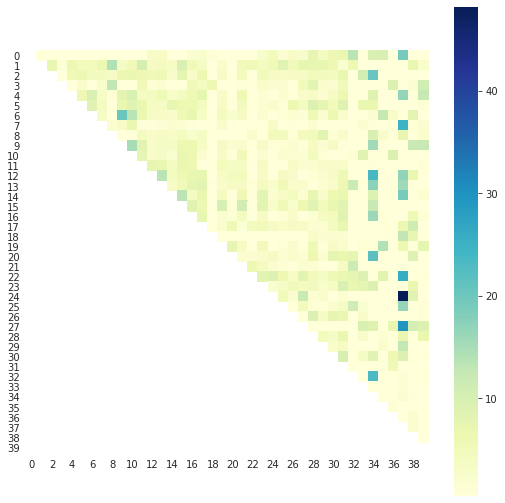

In [476]:
# parameter
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
epoch_idx = 14
alpha=1e-3
#####

singleEpochSPMI_matrix_zth_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epoch'+str(epoch_idx)+'_SPMI_m_zth.eps')

SPMI_singleEpoch_zth = SPMI_withoutD[epoch_idx].copy()
SPMI_singleEpoch_zth = np.triu(SPMI_singleEpoch_zth)
t_stats = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
p_values = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
sig_cons_mask = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
for ch1_idx in range(SPMI_withoutD.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_withoutD.shape[2]):
        SPMI_2chs_bsrg_dstbt = SPMI_bsrg_dstbts[ch1_idx,ch2_idx,:] 
        t_stat,p_value = stats.ttest_1samp(SPMI_2chs_bsrg_dstbt,SPMI_singleEpoch_zth[ch1_idx,ch2_idx])
        t_stats[ch1_idx][ch2_idx] = t_stat
        p_values[ch1_idx][ch2_idx] = p_value
        if t_stat < 0 and p_value/2<alpha:
            sig_cons_mask[ch1_idx][ch2_idx] = True
            SPMI_singleEpoch_zth[ch1_idx][ch2_idx] = (SPMI_singleEpoch_zth[ch1_idx,ch2_idx]- \
                                                      np.mean(SPMI_2chs_bsrg_dstbt))/np.std(SPMI_2chs_bsrg_dstbt)
SPMI_singleEpoch_zth = SPMI_singleEpoch_zth* sig_cons_mask

mask = np.zeros_like(SPMI_singleEpoch_zth)
mask[np.tril_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(SPMI_singleEpoch_zth, mask=mask,vmin =.5, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(singleEpochSPMI_matrix_zth_fName)
#####################################################################

### Step 1-2: single epoch visualization - zth graph

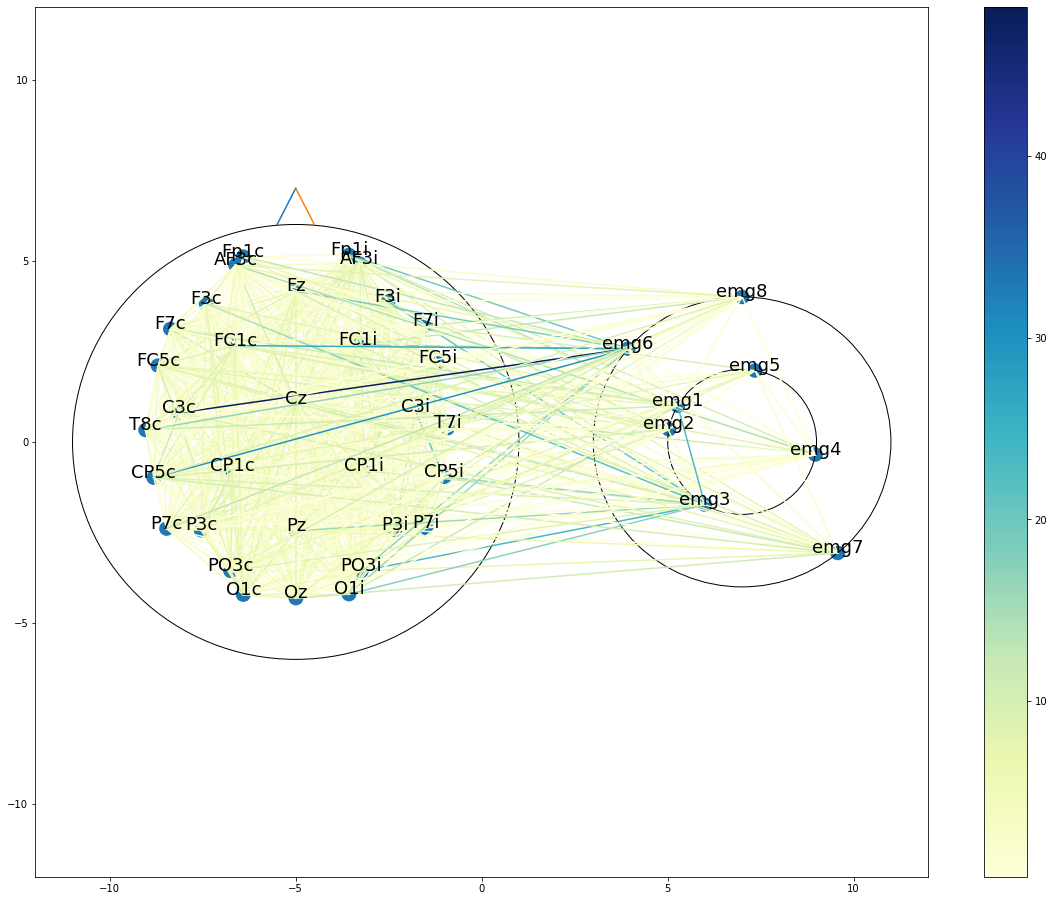

In [477]:
########### customization ###################
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

EMGs=[EMGChannel(2,150,'emg1'),EMGChannel(2,170,'emg2'),EMGChannel(2, 240,'emg3'),EMGChannel(2,350,'emg4'),
      EMGChannel(2, 80,'emg5'),EMGChannel(4,140,'emg6'),EMGChannel(4, 310,'emg7'),
      EMGChannel(4,90,'emg8')]

EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image] 

singleEpochSPMI_g_zth_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epoch'+str(epoch_idx)+'_SPMI_g_zth.eps')
#########################################

fig,ax = plt.subplots(figsize=(20, 16))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
fig,ax = graph_plot(SPMI_singleEpoch_zth,fig,ax)

plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()
fig.savefig(singleEpochSPMI_g_zth_fName)


### Step 2-1: single epoch visualization - ztl matrix (z transformation, t test, lower than bsrg)

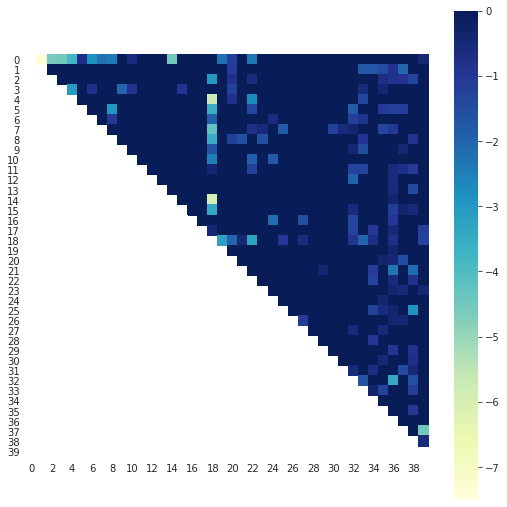

In [478]:
# parameter
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
epoch_idx = 14
alpha=1e-3
#####

singleEpochSPMI_matrix_ztl_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epoch'+str(epoch_idx)+'_SPMI_m_ztl.eps')

SPMI_singleEpoch_ztl = SPMI_withoutD[epoch_idx].copy()
SPMI_singleEpoch_ztl = np.triu(SPMI_singleEpoch_ztl)
t_stats = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
p_values = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
sig_cons_mask = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
for ch1_idx in range(SPMI_withoutD.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_withoutD.shape[2]):
        SPMI_2chs_bsrg_dstbt = SPMI_bsrg_dstbts[ch1_idx,ch2_idx,:] 
        t_stat,p_value = stats.ttest_1samp(SPMI_2chs_bsrg_dstbt,SPMI_singleEpoch_ztl[ch1_idx,ch2_idx])
        t_stats[ch1_idx][ch2_idx] = t_stat
        p_values[ch1_idx][ch2_idx] = p_value
        if t_stat > 0 and p_value/2<alpha:
            sig_cons_mask[ch1_idx][ch2_idx] = True
            SPMI_singleEpoch_ztl[ch1_idx][ch2_idx] = (SPMI_singleEpoch_ztl[ch1_idx,ch2_idx]- \
                                                      np.mean(SPMI_2chs_bsrg_dstbt))/np.std(SPMI_2chs_bsrg_dstbt)
SPMI_singleEpoch_ztl = SPMI_singleEpoch_ztl* sig_cons_mask

mask = np.zeros_like(SPMI_singleEpoch_ztl)
mask[np.tril_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(SPMI_singleEpoch_ztl, mask=mask, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(singleEpochSPMI_matrix_ztl_fName)
#####################################################################

### Step 2-2: single epoch visualization - ztl graph

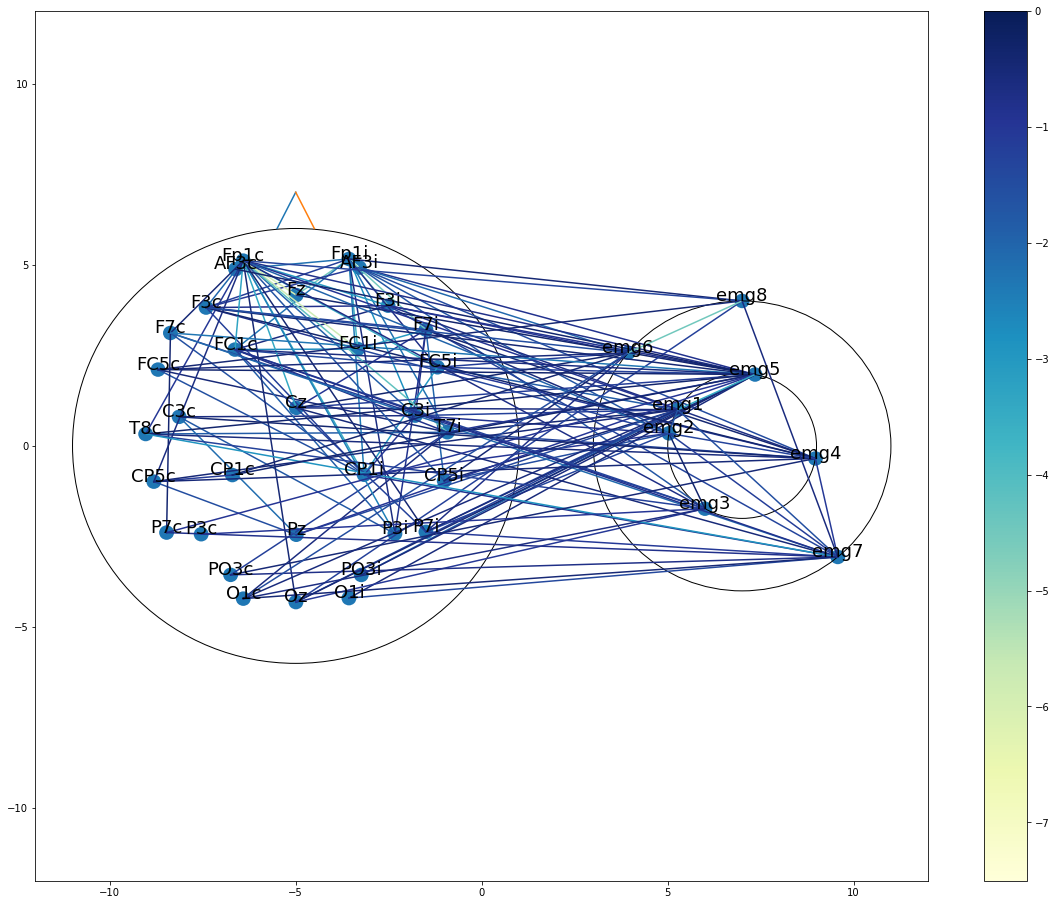

In [479]:
########### customization ###################
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

EMGs=[EMGChannel(2,150,'emg1'),EMGChannel(2,170,'emg2'),EMGChannel(2, 240,'emg3'),EMGChannel(2,350,'emg4'),
      EMGChannel(2, 80,'emg5'),EMGChannel(4,140,'emg6'),EMGChannel(4, 310,'emg7'),
      EMGChannel(4,90,'emg8')]

EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image] 

singleEpochSPMI_g_ztl_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epoch'+str(epoch_idx)+'_SPMI_g_ztl.eps')
#########################################

fig,ax = plt.subplots(figsize=(20, 16))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
fig,ax = graph_plot(SPMI_singleEpoch_ztl,fig,ax)

plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()
fig.savefig(singleEpochSPMI_g_ztl_fName)


## Multi epochs analysis (single subject)
### Step 1-1: visualization - z matrix

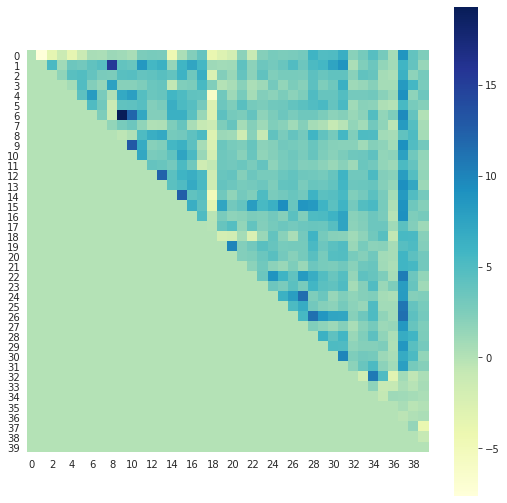

In [480]:
######## import #########
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# ########################distribution check - Normal
# import matplotlib.pyplot as plt
# plt.hist(SPMI_withoutD[:,0,7])
# #############

########## Customization ##########
epochsSPMI_matrix_z_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epochs_SPMI_zm.eps')
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(SPMI_withoutD_z, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(epochsSPMI_matrix_z_fName)

### Step 1-2: visualization - z graph

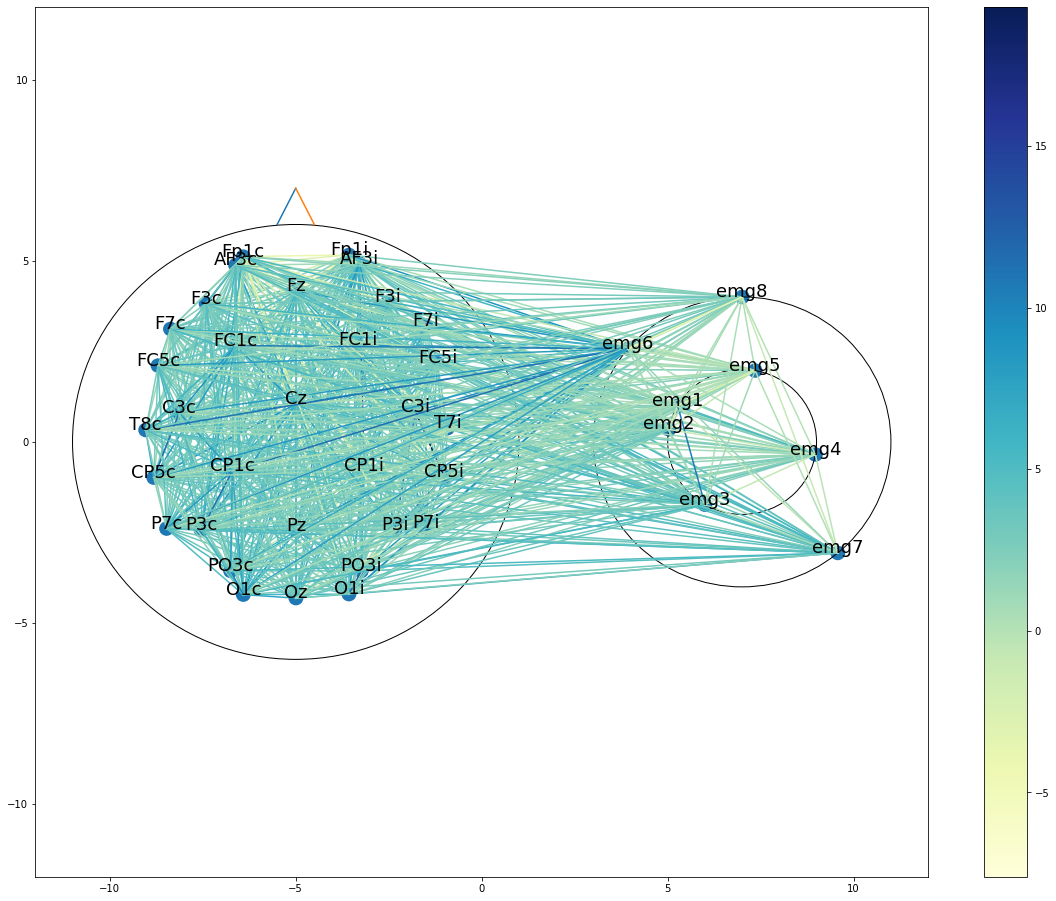

In [481]:
########### customization ###################
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

EMGs=[EMGChannel(2,150,'emg1'),EMGChannel(2,170,'emg2'),EMGChannel(2, 240,'emg3'),EMGChannel(2,350,'emg4'),
      EMGChannel(2, 80,'emg5'),EMGChannel(4,140,'emg6'),EMGChannel(4, 310,'emg7'),
      EMGChannel(4,90,'emg8')]

EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image] 

epochsSPMI_graph_z_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epochs_SPMI_zg.eps')
#########################################

fig,ax = plt.subplots(figsize=(20, 16))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
fig,ax = graph_plot(SPMI_withoutD_z,fig,ax)

plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()
fig.savefig(epochsSPMI_graph_z_fName)


### Step 2-1: visualization - zth matrix

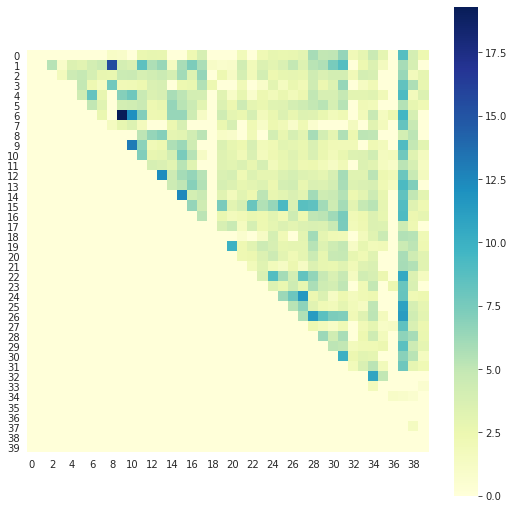

In [482]:
######## import #########
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# ########################distribution check - Normal
# import matplotlib.pyplot as plt
# plt.hist(SPMI_withoutD[:,0,7])
# #############

########## Customization ##########
epochsSPMI_matrix_zth_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epochs_SPMI_zthm.eps')
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(SPMI_withoutD_zth, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(epochsSPMI_matrix_zth_fName)

### Step 2-2: visualization - zth graph

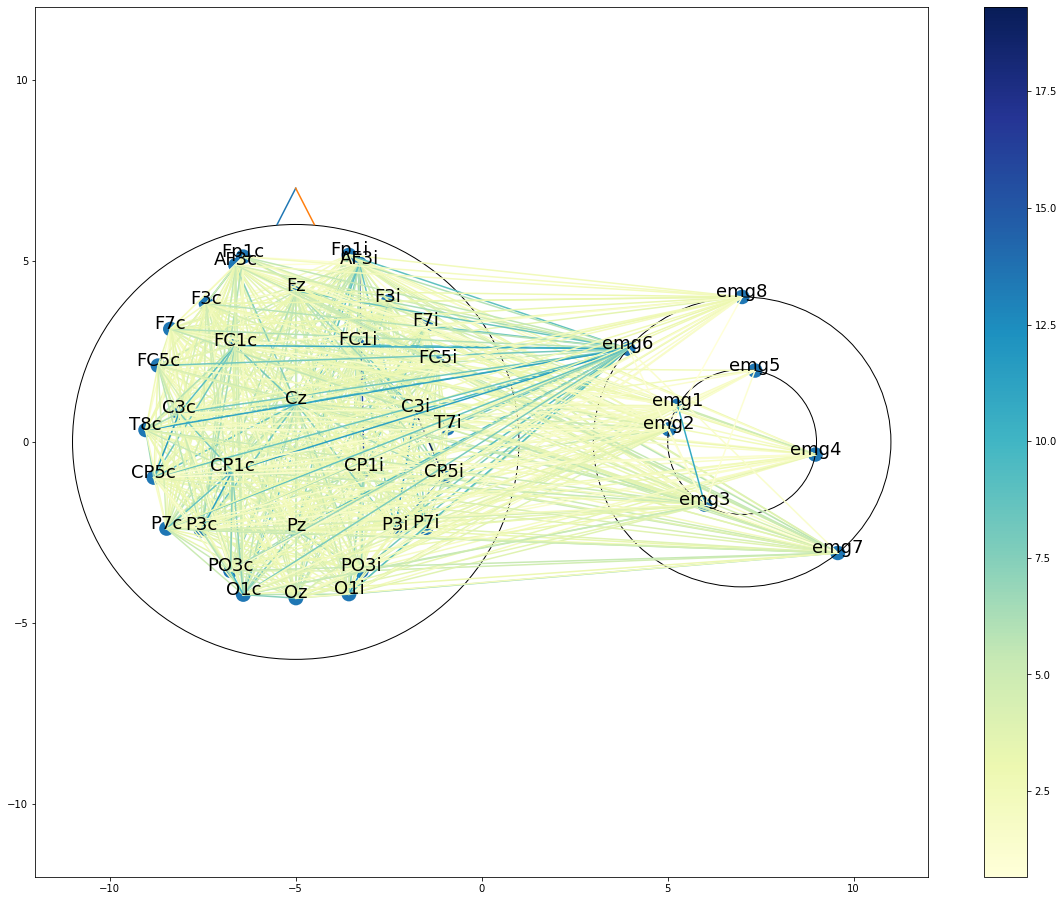

In [483]:
########### customization ###################
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

EMGs=[EMGChannel(2,150,'emg1'),EMGChannel(2,170,'emg2'),EMGChannel(2, 240,'emg3'),EMGChannel(2,350,'emg4'),
      EMGChannel(2, 80,'emg5'),EMGChannel(4,140,'emg6'),EMGChannel(4, 310,'emg7'),
      EMGChannel(4,90,'emg8')]

EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image] 

epochsSPMI_graph_zth_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epochs_SPMI_zthg.eps')
#########################################

fig,ax = plt.subplots(figsize=(20, 16))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
fig,ax = graph_plot(SPMI_withoutD_zth,fig,ax)

plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()
fig.savefig(epochsSPMI_graph_zth_fName)


## Statistical analysis - group effect (healthy subjects vs patients)
### Step 1: data grouping - reruning from here

In [4]:
import os
healthy_subj = ['14','15','17','18','19','21']
# healthy_subj = ['4','14']
stroke_subj = ['10','20','24','25','30','32','34','35']
data_dir = 'D:/Data/MultiEEGEMG_stroke/'
# data_dir = 'E:/important file/Projects/CM-graph/sample_data' #PC dir
global_results_dir = os.path.join(data_dir,'results')
contraction_type = 'iMC'
session_idx = 's01'
if not os.path.exists(global_results_dir):
    os.makedirs(global_results_dir)
SPMI_withoutD_z_healthy = []
SPMI_withoutD_z_stroke = []
for subj_idx in healthy_subj:
    SPMI_withoutD_z_fName = os.path.join(data_dir,'subj'+subj_idx,'temp',contraction_type+'_'+session_idx+'_z_meanSPMI')
    SPMI_withoutD_z = np.load(SPMI_withoutD_z_fName+'.npy')
    SPMI_withoutD_z_healthy.append(SPMI_withoutD_z)
for subj_idx in stroke_subj:
    SPMI_withoutD_z_fName = os.path.join(data_dir,'subj'+subj_idx,'temp',contraction_type+'_'+session_idx+'_z_meanSPMI')
    SPMI_withoutD_z = np.load(SPMI_withoutD_z_fName+'.npy')
    SPMI_withoutD_z_stroke.append(SPMI_withoutD_z)
SPMI_withoutD_z_healthy = np.array(SPMI_withoutD_z_healthy)
SPMI_withoutD_z_stroke = np.array(SPMI_withoutD_z_stroke)

### Step 2: visualization of significant group difference - z matrix (alpha=1e-3)

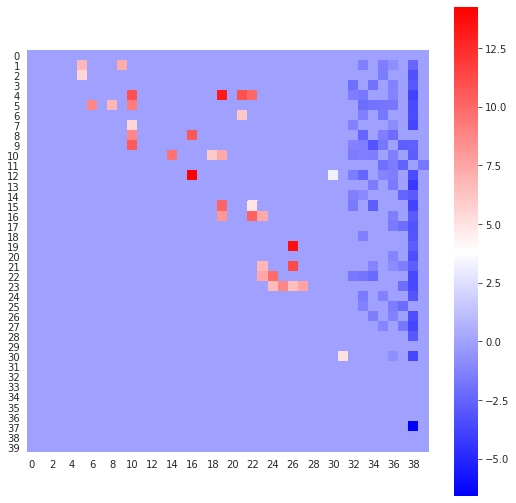

In [9]:
# normality check 
# import matplotlib.pyplot as plt
# plt.hist(SPMI_withoutD_z_healthy[:,30,35])
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
global_results_dir = os.path.join(data_dir,'results')
if not os.path.exists(global_results_dir):
    os.makedirs(global_results_dir)
con_diff_healthyStroke_m_fName = os.path.join(global_results_dir,
                                 'con_diff_healthyStroke_m.eps')
alpha = 5e-2
t_stats = np.zeros((SPMI_withoutD_z_healthy.shape[1],SPMI_withoutD_z_healthy.shape[2]))
p_values = np.zeros((SPMI_withoutD_z_healthy.shape[1],SPMI_withoutD_z_healthy.shape[2]))
sig_cons_mask = np.zeros((SPMI_withoutD_z_healthy.shape[1],SPMI_withoutD_z_healthy.shape[2]))
for ch1_idx in range(SPMI_withoutD_z_healthy.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_withoutD_z_healthy.shape[2]):
        SPMI_ch1ch2_healthy = SPMI_withoutD_z_healthy[:,ch1_idx,ch2_idx]
        SPMI_ch1ch2_stroke = SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx] 
        t_stat,p_value = stats.ttest_ind(SPMI_ch1ch2_healthy,SPMI_ch1ch2_stroke)
        t_stats[ch1_idx][ch2_idx] = t_stat
        p_values[ch1_idx][ch2_idx] = p_value
        if p_value < alpha:
            sig_cons_mask[ch1_idx][ch2_idx] = True
con_diff_healthyMinusStroke = (np.mean(SPMI_withoutD_z_healthy,axis=0)-np.mean(SPMI_withoutD_z_stroke,axis=0))\
* sig_cons_mask
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(con_diff_healthyMinusStroke, square=True,cmap="bwr")
    figure = ax.get_figure()
    figure.savefig(con_diff_healthyStroke_m_fName)

### Step 3: visualization of significant group difference - graph
- changes to be made on the location

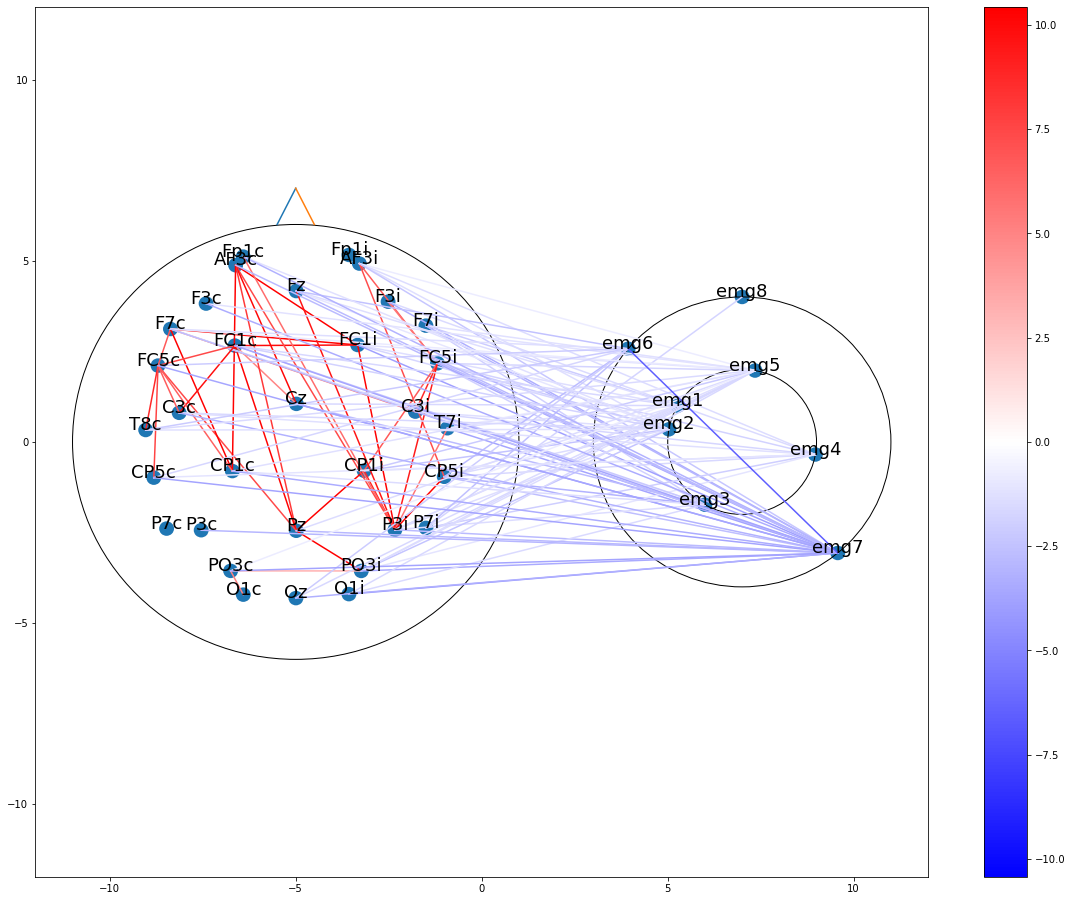

In [12]:
########### customization ###################
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

EMGs=[EMGChannel(2,150,'emg1'),EMGChannel(2,170,'emg2'),EMGChannel(2, 240,'emg3'),EMGChannel(2,350,'emg4'),
      EMGChannel(2, 80,'emg5'),EMGChannel(4,140,'emg6'),EMGChannel(4, 310,'emg7'),
      EMGChannel(4,90,'emg8')]

EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image] 

con_diff_healthyStroke_g_fName = os.path.join(global_results_dir,'con_diff_healthyStroke_g.eps')
#########################################

# fig= plt.figure(figsize=(18, 18), facecolor='w', edgecolor='k')
fig,ax = plt.subplots(figsize=(20, 16))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
fig,ax = graph_plot_fixMapper(con_diff_healthyMinusStroke,con_diff_healthyMinusStroke,fig,ax)
# fig.colorbar(ax.images,cax,ax=ax)

plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()
# fig.savefig(con_diff_healthyStroke_g_fName)

## step 4: find significantly different connection and correlate them with FMA

In [115]:
import scipy
from numpy import mean
from numpy import var
from math import sqrt
def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = mean(d1), mean(d2)
    return (u1 - u2) / s

sig_cons=[]
for ch1_idx in range(SPMI_withoutD_z.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_withoutD_z.shape[1]):
        if sig_cons_mask[ch1_idx][ch2_idx] != 0: # significant diff
            ch1_name = chs_list_image[ch1_idx]
            ch2_name = chs_list_image[ch2_idx]
            t_stat,pvalue = scipy.stats.ttest_ind(SPMI_withoutD_z_healthy[:,ch1_idx,ch2_idx],
                          SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx], equal_var=False)
            cohen_s_d = round(cohend(SPMI_withoutD_z_healthy[:,ch1_idx,ch2_idx],
                 SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx]),2)
            sig_cons.append([ch1_name,ch2_name])
            print(ch1_name +'-'+ ch2_name + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),
                                                                                                cohen_s_d,
                                                                                                round(t_stat,2)))
data_dir = 'D:/Data/MultiEEGEMG_stroke/'
subjInfo_fName = os.path.join(data_dir,'subj_info.txt')
subjInfo = pd.read_csv(subjInfo_fName, skiprows=0,
                       sep = ',',engine = 'python') 
FMAs=[]
for subj_idx in stroke_subj:
    df_info = subjInfo[subjInfo['subj_idx']==int(subj_idx)]
#     df_info.reset_index(drop=True,inplace=True)
    FMAs.append(df_info['FMA'].values[0])



import statsmodels.api as sm

for sig_con in sig_cons:
    ch1_idx = chs_list_image.index(sig_con[0])
    ch2_idx = chs_list_image.index(sig_con[1])
    SPMIs = SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx]
    X = SPMIs
    Y = FMAs
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    predictions = model.predict(X)
    if model.f_pvalue<0.01:
        print(str(sig_con))
        print(model.summary())
                

AF3i-FC5i: pvalue = 0.05, cohen's d = 1.38, t_stat = 2.38
AF3i-CP5i: pvalue = 0.09, cohen's d = 1.26, t_stat = 2.03
AF3i-emg2: pvalue = 0.03, cohen's d = -1.3, t_stat = -2.52
AF3i-emg4: pvalue = 0.04, cohen's d = -1.19, t_stat = -2.32
AF3i-emg5: pvalue = 0.05, cohen's d = -1.21, t_stat = -2.23
AF3i-emg7: pvalue = 0.03, cohen's d = -1.31, t_stat = -2.46
F3i-FC5i: pvalue = 0.02, cohen's d = 1.89, t_stat = 3.13
F3i-emg4: pvalue = 0.04, cohen's d = -1.29, t_stat = -2.37
F3i-emg7: pvalue = 0.01, cohen's d = -1.74, t_stat = -3.13
F7i-emg1: pvalue = 0.01, cohen's d = -1.6, t_stat = -3.21
F7i-emg3: pvalue = 0.03, cohen's d = -1.22, t_stat = -2.42
F7i-emg5: pvalue = 0.02, cohen's d = -1.4, t_stat = -2.67
F7i-emg7: pvalue = 0.0, cohen's d = -1.97, t_stat = -3.81
FC1i-P3i: pvalue = 0.06, cohen's d = 1.19, t_stat = 2.13
FC1i-AF3c: pvalue = 0.01, cohen's d = 1.94, t_stat = 3.28
FC1i-F7c: pvalue = 0.06, cohen's d = 1.4, t_stat = 2.33
FC1i-FC1c: pvalue = 0.07, cohen's d = 1.23, t_stat = 2.13
FC1i-emg

d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


## step 5: visualisation of reg

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


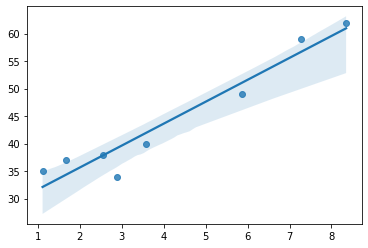

In [122]:
import seaborn as sns
ch1_name = 'FC1c'
ch2_name = 'emg7'
ch1_idx = chs_list_image.index(ch1_name)
ch2_idx = chs_list_image.index(ch2_name)
SPMIs = SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx]
ax = sns.regplot(x=SPMIs, y=FMAs)
regPlot_fName = os.path.join(global_results_dir,ch1_name+'-'+ch2_name+'FMAreg.eps')
figure = ax.get_figure()
figure.savefig(regPlot_fName)

## step 6: surrogate reg model

In [37]:
# O1i-emg7,Oz-emg7,FC1c-emg2, T8c-emg5, CP5c-emg7
ch1_idx = chs_list_image.index('C3i')
ch2_idx = chs_list_image.index('emg7')
SPMIs_x1 = SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx]
ch1_idx = chs_list_image.index('T7i')
ch2_idx = chs_list_image.index('emg1')
SPMIs_x2 = SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx]
ch1_idx = chs_list_image.index('P7i')
ch2_idx = chs_list_image.index('emg6')
SPMIs_x3 = SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx]
ch1_idx = chs_list_image.index('FC1c')
ch2_idx = chs_list_image.index('emg7')
SPMIs_x4 = SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx]
ch1_idx = chs_list_image.index('F3i')
ch2_idx = chs_list_image.index('emg1')
SPMIs_x5 = SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx]
ch1_idx = chs_list_image.index('O1i')
ch2_idx = chs_list_image.index('emg6')
SPMIs_x6 = SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx]
ch1_idx = chs_list_image.index('C3c')
ch2_idx = chs_list_image.index('emg6')
SPMIs_x7 = SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx]
import statsmodels.api as sm
# X = np.array([SPMIs_x1,SPMIs_x2,SPMIs_x3,SPMIs_x4,SPMIs_x5,SPMIs_x6,SPMIs_x7]).T
X = np.array([SPMIs_x2,SPMIs_x3,SPMIs_x4,SPMIs_x5,SPMIs_x6]).T
Y = FMAs
X=sm.add_constant(X)
model = sm.OLS(Y,X).fit()
predictions = model.predict(X)
model.summary()

d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     105.3
Date:                Wed, 27 Jan 2021   Prob (F-statistic):            0.00944
Time:                        10:09:57   Log-Likelihood:                -7.7338
No. Observations:                   8   AIC:                             27.47
Df Residuals:                       2   BIC:                             27.94
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.3298      2.012     14.077      0.005      19.671      36.989
x1             1.0539      1.254      0.841      0.489      -4.341       6.448
x2             1.8216      0.499      3.650      0.068      -0.326       3.969
x3            -0.1772      1.175     -0.151      0.894      -5.232       4.878
x4             4.5647      2.174      2.099      0.171      -4.791      13.921
x5            -0.1229      0.401     -0.306      0.788      -1.849       1.604
==============================================================================
Omnibus:                        0.377   Durbin-Watson:                   2.598
Prob(Omnibus):                  0.828   Jarque-Bera (JB):                0.174
Skew:                           0.265   Prob(JB):                        0.917
Kurtosis:                       2.509   Cond. No.                         58.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
print(Y)
print(predictions)

[34.0, 35.0, 37.0, 38.0, 59.0, 49.0, 62.0, 40.0]
[34.00602879 34.69403706 37.25862284 37.25453669 59.48960352 49.45188202
 61.18980236 40.65548672]


## step 7: exhaustic search for connections associated with FMA

In [14]:
import scipy
from numpy import mean
from numpy import var
from math import sqrt
def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = mean(d1), mean(d2)
    return (u1 - u2) / s

sig_cons=[]
for ch1_idx in range(SPMI_withoutD_z.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_withoutD_z.shape[1]):
        ch1_name = chs_list_image[ch1_idx]
        ch2_name = chs_list_image[ch2_idx]
        t_stat,pvalue = scipy.stats.ttest_ind(SPMI_withoutD_z_healthy[:,ch1_idx,ch2_idx],
                      SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx], equal_var=False)
        cohen_s_d = round(cohend(SPMI_withoutD_z_healthy[:,ch1_idx,ch2_idx],
             SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx]),2)
        sig_cons.append([ch1_name,ch2_name])
#         print(ch1_name +'-'+ ch2_name + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),
#                                                                                                 cohen_s_d,
#                                                                                                 round(t_stat,2)))
data_dir = 'D:/Data/MultiEEGEMG_stroke/'
subjInfo_fName = os.path.join(data_dir,'subj_info.txt')
subjInfo = pd.read_csv(subjInfo_fName, skiprows=0,
                       sep = ',',engine = 'python') 
FMAs=[]
for subj_idx in stroke_subj:
    df_info = subjInfo[subjInfo['subj_idx']==int(subj_idx)]
#     df_info.reset_index(drop=True,inplace=True)
    FMAs.append(df_info['FMA'].values[0])



import statsmodels.api as sm

for sig_con in sig_cons:
    ch1_idx = chs_list_image.index(sig_con[0])
    ch2_idx = chs_list_image.index(sig_con[1])
    SPMIs = SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx]
    X = SPMIs
    Y = FMAs
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    predictions = model.predict(X)
    if model.f_pvalue<0.01:
        print(str(sig_con))
        print(model.summary())
                

['F3i', 'emg1']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     96.84
Date:                Tue, 26 Jan 2021   Prob (F-statistic):           6.35e-05
Time:                        12:44:37   Log-Likelihood:                -18.675
No. Observations:                   8   AIC:                             41.35
Df Residuals:                       6   BIC:                             41.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.6006      1.641    

d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


['P7i', 'emg6']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     29.25
Date:                Tue, 26 Jan 2021   Prob (F-statistic):            0.00165
Time:                        12:44:37   Log-Likelihood:                -22.958
No. Observations:                   8   AIC:                             49.92
Df Residuals:                       6   BIC:                             50.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.0882      3.301    

d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


## regplot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


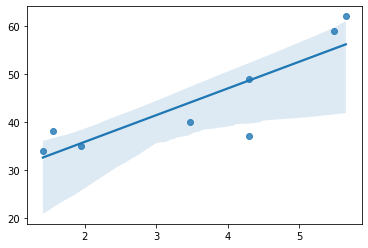

In [35]:
import seaborn as sns
ch1_name = 'C3c'
ch2_name = 'emg6'
ch1_idx = chs_list_image.index(ch1_name)
ch2_idx = chs_list_image.index(ch2_name)
SPMIs = SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx]
ax = sns.regplot(x=SPMIs, y=FMAs)
regPlot_fName = os.path.join(global_results_dir,ch1_name+'-'+ch2_name+'FMAreg.eps')
figure = ax.get_figure()
figure.savefig(regPlot_fName)

## step 7 (optional): surrogate boxplot

FC5i-emg5_healthy v.s. FC5i-emg5_stroke: t-test independent samples with Bonferroni correction, P_val=1.066e-01 stat=-3.698e+00
FC5i-emg7_healthy v.s. FC5i-emg7_stroke: t-test independent samples with Bonferroni correction, P_val=6.239e-02 stat=-3.993e+00
T7i-emg7_healthy v.s. T7i-emg7_stroke: t-test independent samples with Bonferroni correction, P_val=1.583e-01 stat=-3.483e+00
CP1i-emg2_healthy v.s. CP1i-emg2_stroke: t-test independent samples with Bonferroni correction, P_val=1.826e-01 stat=-3.405e+00
CP5i-emg3_healthy v.s. CP5i-emg3_stroke: t-test independent samples with Bonferroni correction, P_val=4.786e-04 stat=-7.034e+00
CP5i-emg6_healthy v.s. CP5i-emg6_stroke: t-test independent samples with Bonferroni correction, P_val=8.242e-02 stat=-3.839e+00
CP5i-emg7_healthy v.s. CP5i-emg7_stroke: t-test independent samples with Bonferroni correction, P_val=4.191e-02 stat=-4.216e+00
P7i-emg5_healthy v.s. P7i-emg5_stroke: t-test independent samples with Bonferroni correction, P_val=6.314e

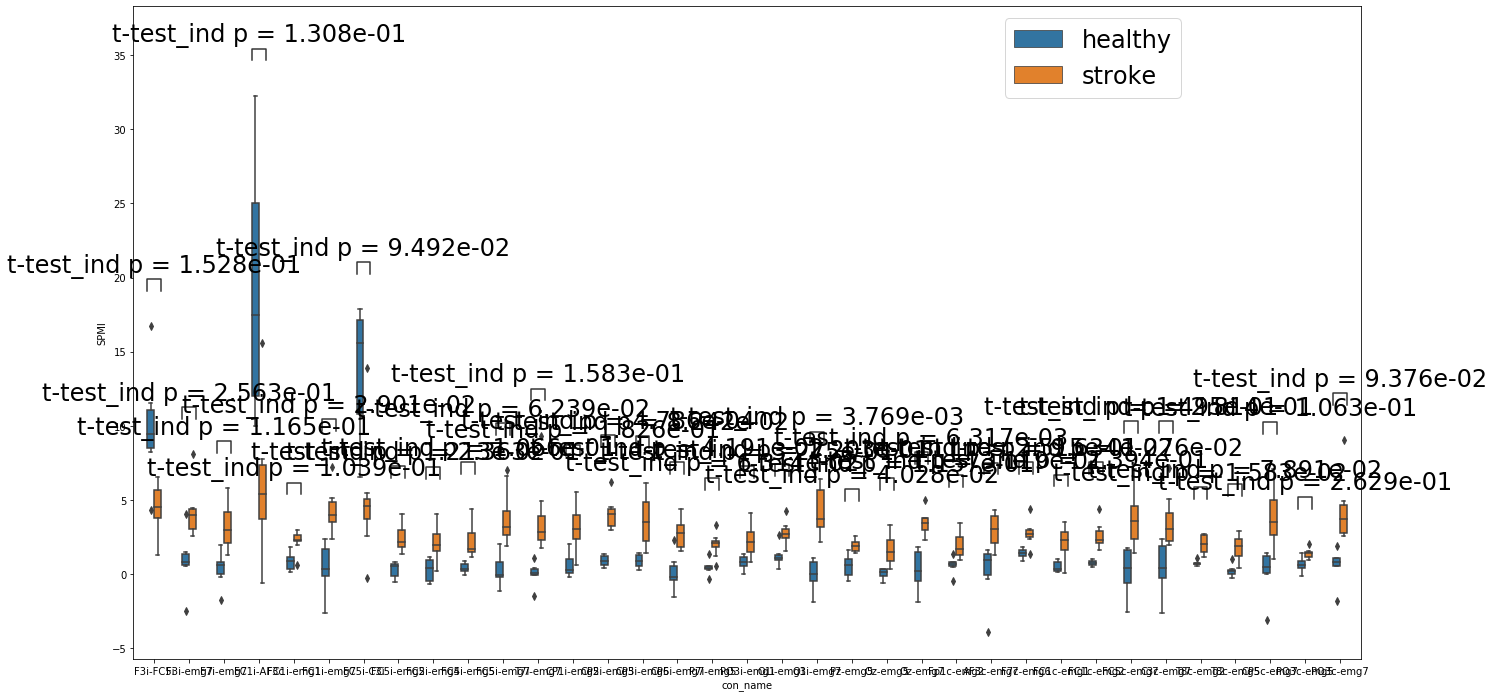

In [648]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
# df = None
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
dfs2concate = []
con_sig_name=[]
fig,ax = plt.subplots(figsize=(22, 12))
for ch1_idx in range(SPMI_withoutD_z.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_withoutD_z.shape[1]):
        if sig_cons_mask[ch1_idx][ch2_idx] != 0: # significant diff
            ch1_name = chs_list_image[ch1_idx]
            ch2_name = chs_list_image[ch2_idx]
            con_name = [ch1_name +'-'+ ch2_name]*(len(healthy_subj)+len(stroke_subj))
            con_sig_name.append(con_name[0])
            SPMI4df = np.concatenate((SPMI_withoutD_z_healthy[:,ch1_idx,ch2_idx],SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx]))
#             print(con_name[0])
#             print(SPMI_withoutD_z_healthy[:,ch1_idx,ch2_idx])
#             print(SPMI_withoutD_z_stroke[:,ch1_idx,ch2_idx])
            order = np.concatenate((np.array(['healthy']*len(healthy_subj)),np.array(['stroke']*len(stroke_subj))))
            data = {'con_name':con_name,'SPMI':SPMI4df,'order':order}
            dfs2concate.append(pd.DataFrame(data, columns = ['con_name','SPMI','order']))

df = pd.concat(dfs2concate)
            
x = 'con_name'
y = 'SPMI'
hue = 'order'
ax = sns.boxplot(data=df, x=x, y=y, hue=hue,ax=ax,width = 0.4)
add_stat_annotation(ax,data=df, x=x, y=y, 
            box_pairs=[((con_sig_name[i],"healthy"),(con_sig_name[i],"stroke")) 
                       for i in range(int(len(df['con_name'])/((len(healthy_subj)+len(stroke_subj)))))],
            hue=hue,test='t-test_ind',text_format='full',fontsize=24,verbose=1)
plt.legend(loc='upper left', bbox_to_anchor = (0.7,1),prop={'size': 24})
con_diff_healthyStroke_bp_fName = os.path.join(global_results_dir,'healthyStroke_sigConnection_bp.eps')
# plt.savefig(con_diff_healthyStroke_bp_fName)
# plt.cla()


## Statistical analysis - intervetion effect (pre_TMS vs post_TMS)
### Step 1: data grouping

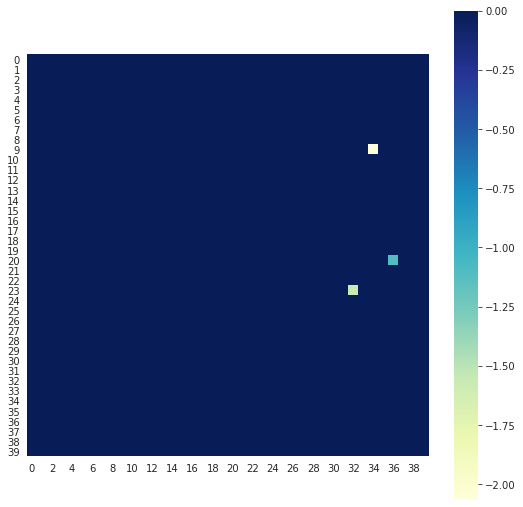

In [92]:
import os, numpy as np, mne
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
stroke_subj = ['10','20','24','25','30','32','34','35']
data_dir = 'D:/Data/MultiEEGEMG_stroke/'
# data_dir = 'E:/important file/Projects/CM-graph/sample_data' #PC dir
global_results_dir = os.path.join(data_dir,'results')
contraction_type = 'iMC'
if not os.path.exists(global_results_dir):
    os.makedirs(global_results_dir)
SPMI_withoutD_z_preTMS = []
SPMI_withoutD_z_postTMS = []
for subj_idx in stroke_subj:
    SPMI_withoutD_z_fName = os.path.join(data_dir,'subj'+subj_idx,'temp',contraction_type+'_s01_z_meanSPMI')
    SPMI_withoutD_z = np.load(SPMI_withoutD_z_fName+'.npy')
    SPMI_withoutD_z_preTMS.append(SPMI_withoutD_z)
    SPMI_withoutD_z_fName = os.path.join(data_dir,'subj'+subj_idx,'temp',contraction_type+'_s02_z_meanSPMI')
    SPMI_withoutD_z = np.load(SPMI_withoutD_z_fName+'.npy')
    SPMI_withoutD_z_postTMS.append(SPMI_withoutD_z)
SPMI_withoutD_z_preTMS = np.array(SPMI_withoutD_z_preTMS)
SPMI_withoutD_z_postTMS = np.array(SPMI_withoutD_z_postTMS)
# normality check 
# import matplotlib.pyplot as plt
# plt.hist(SPMI_withoutD_z_healthy[:,30,35])


con_diff_prePostTMS_m_fName = os.path.join(global_results_dir,
                                 'con_diff_prePostTMS_m.eps')
alpha = 1e-2
t_stats = np.zeros((SPMI_withoutD_z_preTMS.shape[1],SPMI_withoutD_z_postTMS.shape[2]))
p_values = np.zeros((SPMI_withoutD_z_preTMS.shape[1],SPMI_withoutD_z_postTMS.shape[2]))
sig_cons_mask = np.zeros((SPMI_withoutD_z_preTMS.shape[1],SPMI_withoutD_z_postTMS.shape[2]))
for ch1_idx in range(SPMI_withoutD_z_preTMS.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_withoutD_z_preTMS.shape[2]):
        SPMI_ch1ch2_preTMS = SPMI_withoutD_z_preTMS[:,ch1_idx,ch2_idx]
        SPMI_ch1ch2_postTMS = SPMI_withoutD_z_postTMS[:,ch1_idx,ch2_idx] 
        t_stat,p_value = stats.ttest_ind(SPMI_ch1ch2_preTMS,SPMI_ch1ch2_postTMS)
        t_stats[ch1_idx][ch2_idx] = t_stat
        p_values[ch1_idx][ch2_idx] = p_value
        if p_value < alpha:
            sig_cons_mask[ch1_idx][ch2_idx] = True
con_diff_postMinusPre = (np.mean(SPMI_withoutD_z_postTMS,axis=0)-np.mean(SPMI_withoutD_z_preTMS,axis=0))\
* sig_cons_mask
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(con_diff_postMinusPre, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
#     figure.savefig(con_diff_prePostTMS_m_fName)

## one-way rmANOVA: PRE-POST

CP5i-emg3
              Anova
      F Value Num DF Den DF Pr > F
----------------------------------
order 32.9780 1.0000 7.0000 0.0007

PO3i-O1i
              Anova
      F Value Num DF Den DF Pr > F
----------------------------------
order 13.6813 1.0000 7.0000 0.0077

FC5c-emg1
              Anova
      F Value Num DF Den DF Pr > F
----------------------------------
order 21.7344 1.0000 7.0000 0.0023

C3c-P3c
              Anova
      F Value Num DF Den DF Pr > F
----------------------------------
order 15.9028 1.0000 7.0000 0.0053



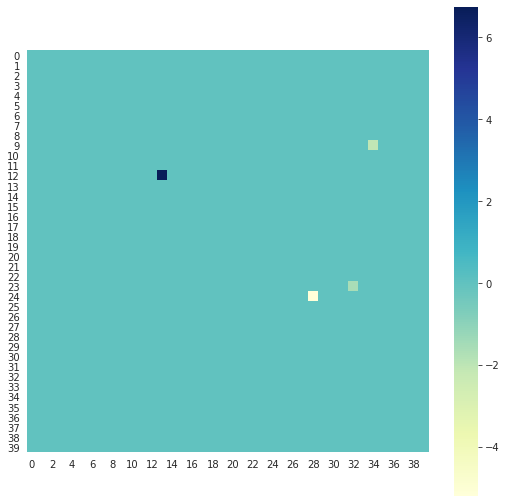

In [94]:
from statsmodels.stats.anova import AnovaRM
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
import os
stroke_subj = ['10','20','24','25','30','32','34','35']
data_dir = 'D:/Data/MultiEEGEMG_stroke/'
# data_dir = 'E:/important file/Projects/CM-graph/sample_data' #PC dir
global_results_dir = os.path.join(data_dir,'results')
contraction_type = 'iMC'
if not os.path.exists(global_results_dir):
    os.makedirs(global_results_dir)
SPMI_withoutD_z_preTMS = []
SPMI_withoutD_z_postTMS = []
for subj_idx in stroke_subj:
    SPMI_withoutD_z_fName = os.path.join(data_dir,'subj'+subj_idx,'temp',contraction_type+'_s01_z_meanSPMI')
    SPMI_withoutD_z = np.load(SPMI_withoutD_z_fName+'.npy')
    SPMI_withoutD_z_preTMS.append(SPMI_withoutD_z)
    SPMI_withoutD_z_fName = os.path.join(data_dir,'subj'+subj_idx,'temp',contraction_type+'_s02_z_meanSPMI')
    SPMI_withoutD_z = np.load(SPMI_withoutD_z_fName+'.npy')
    SPMI_withoutD_z_postTMS.append(SPMI_withoutD_z)
SPMI_withoutD_z_preTMS = np.array(SPMI_withoutD_z_preTMS)
SPMI_withoutD_z_postTMS = np.array(SPMI_withoutD_z_postTMS)

chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

con_diff_prePostTMS_rmANOVA_m_fName = os.path.join(global_results_dir,
                                 'con_diff_prePostTMS_rmANOVA_m.eps')
alpha = 1e-2
sig_cons_mask = np.zeros((SPMI_withoutD_z_preTMS.shape[1],SPMI_withoutD_z_postTMS.shape[2]))
dfs2concate = []
for ch1_idx in range(SPMI_withoutD_z.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_withoutD_z.shape[1]):
        ch1_name = chs_list_image[ch1_idx]
        ch2_name = chs_list_image[ch2_idx]
        con_name = [ch1_name +'-'+ ch2_name]*(len(stroke_subj)+len(stroke_subj))
        SPMI4df = np.concatenate((SPMI_withoutD_z_preTMS[:,ch1_idx,ch2_idx],SPMI_withoutD_z_postTMS[:,ch1_idx,ch2_idx]))
        order = np.concatenate((np.array(['pre']*len(stroke_subj)),np.array(['post']*len(stroke_subj))))
        idx = np.concatenate((np.array(np.arange(len(stroke_subj))),np.array(np.arange(len(stroke_subj)))))
        data = {'idx':idx,'SPMI':SPMI4df,'order':order}
        df = pd.DataFrame(data, columns = ['idx','SPMI','order'])
        aovrm = AnovaRM(df,'SPMI','idx',within=['order'])
        res=aovrm.fit()
        if res.anova_table.get('Pr > F').item()<alpha:
            print(ch1_name +'-'+ ch2_name)
            print(res)
            sig_cons_mask[ch1_idx][ch2_idx] = True
con_diff_postMinusPre = (np.mean(SPMI_withoutD_z_postTMS,axis=0)-np.mean(SPMI_withoutD_z_preTMS,axis=0))\
* sig_cons_mask   
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(con_diff_postMinusPre, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(con_diff_prePostTMS_rmANOVA_m_fName)

# df = pd.concat(dfs2concate)
# df=df.reset_index()
# df=df.rename(columns={'index':'id'})
# df['id']=df.index

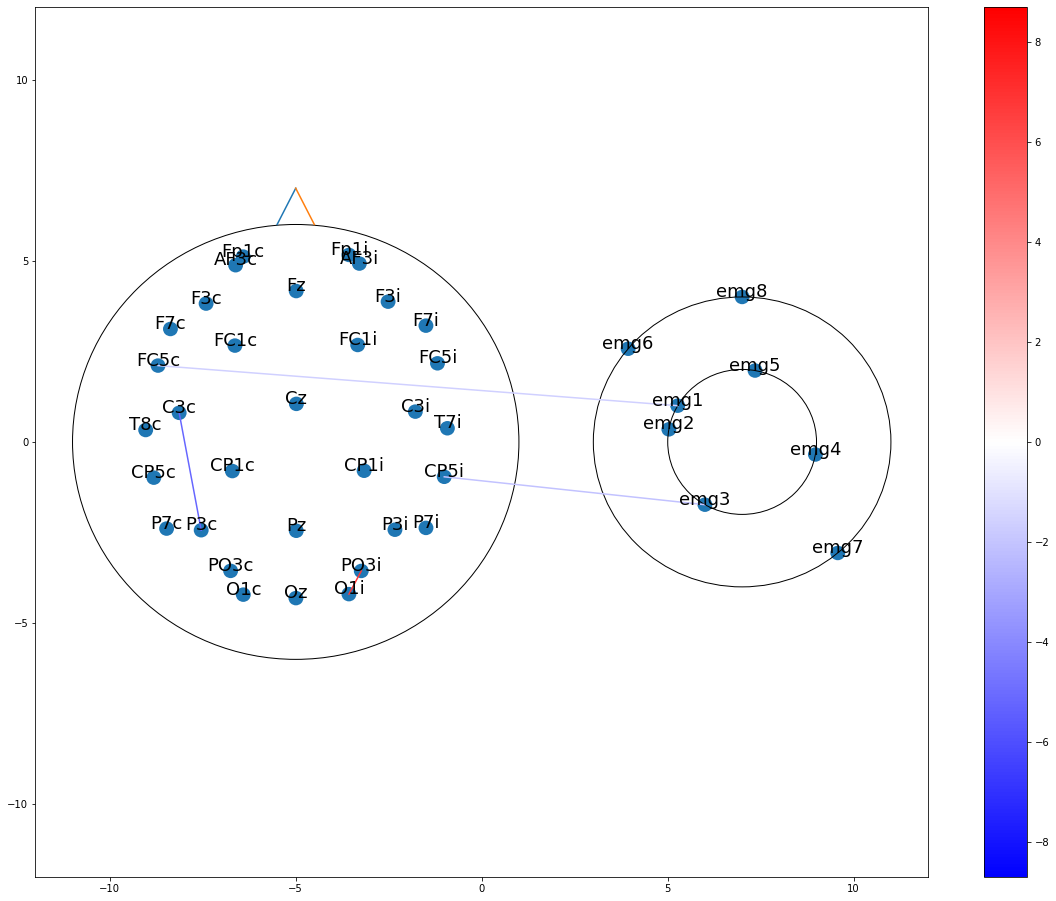

In [95]:
########### customization ###################
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

EMGs=[EMGChannel(2,150,'emg1'),EMGChannel(2,170,'emg2'),EMGChannel(2, 240,'emg3'),EMGChannel(2,350,'emg4'),
      EMGChannel(2, 80,'emg5'),EMGChannel(4,140,'emg6'),EMGChannel(4, 310,'emg7'),
      EMGChannel(4,90,'emg8')]

EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image] 

con_diff_prePostTMS_rmANOVA_g_fName = os.path.join(global_results_dir,'con_diff_prePostTMS_rmANOV_g.eps')
#########################################

# fig= plt.figure(figsize=(18, 18), facecolor='w', edgecolor='k')
fig,ax = plt.subplots(figsize=(20, 16))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
fig,ax = graph_plot_fixMapper(con_diff_postMinusPre,con_diff_healthyMinusStroke,fig,ax)
# fig.colorbar(ax.images,cax,ax=ax)

plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()
# fig.savefig(con_diff_prePostTMS_g_fName)

## t-test

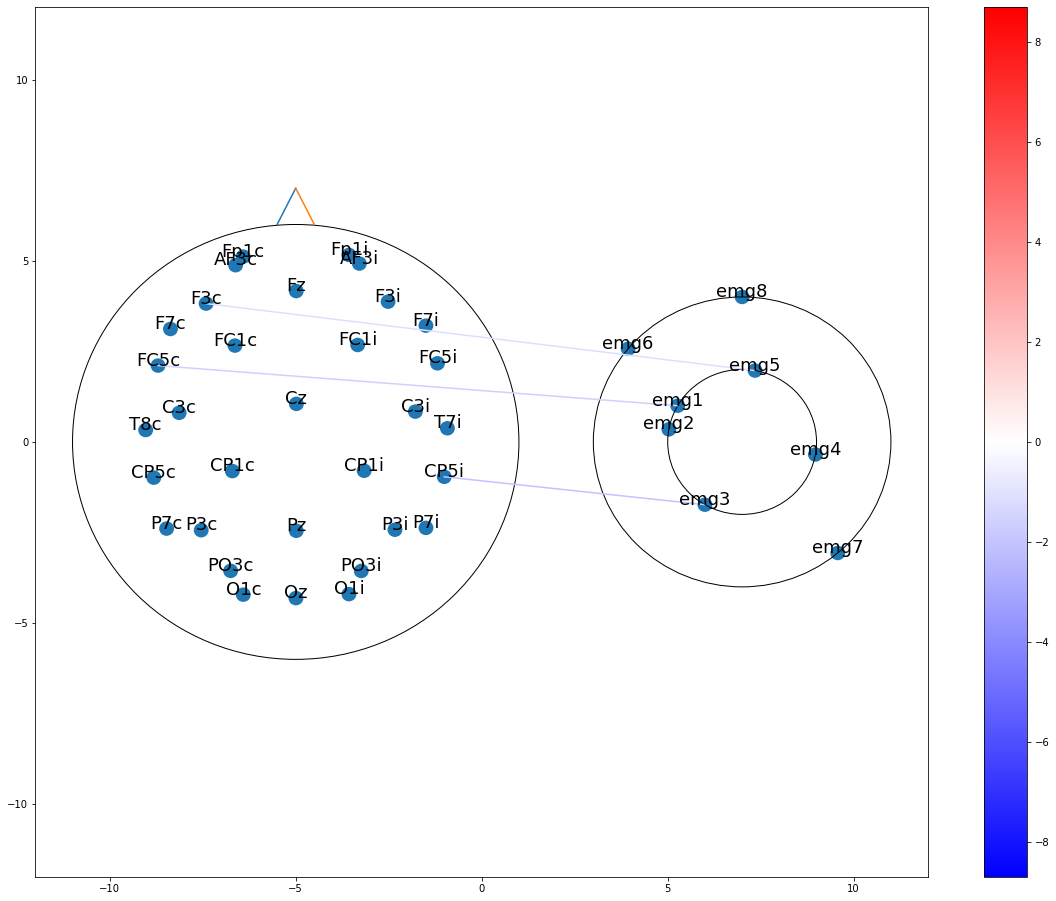

In [93]:
########### customization ###################
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

EMGs=[EMGChannel(2,150,'emg1'),EMGChannel(2,170,'emg2'),EMGChannel(2, 240,'emg3'),EMGChannel(2,350,'emg4'),
      EMGChannel(2, 80,'emg5'),EMGChannel(4,140,'emg6'),EMGChannel(4, 310,'emg7'),
      EMGChannel(4,90,'emg8')]

EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image] 

con_diff_prePostTMS_g_fName = os.path.join(global_results_dir,'con_diff_prePostTMS_g.eps')
#########################################

# fig= plt.figure(figsize=(18, 18), facecolor='w', edgecolor='k')
fig,ax = plt.subplots(figsize=(20, 16))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
fig,ax = graph_plot_fixMapper(con_diff_postMinusPre,con_diff_healthyMinusStroke,fig,ax)
# fig.colorbar(ax.images,cax,ax=ax)

plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()
# fig.savefig(con_diff_prePostTMS_g_fName)

F3c-emg5_pre v.s. F3c-emg5_post: t-test independent samples with Bonferroni correction, P_val=2.421e-02 stat=3.085e+00
CP5i-emg3_pre v.s. CP5i-emg3_post: t-test independent samples with Bonferroni correction, P_val=1.755e-03 stat=4.417e+00
FC5c-emg1_pre v.s. FC5c-emg1_post: t-test independent samples with Bonferroni correction, P_val=2.719e-02 stat=3.026e+00


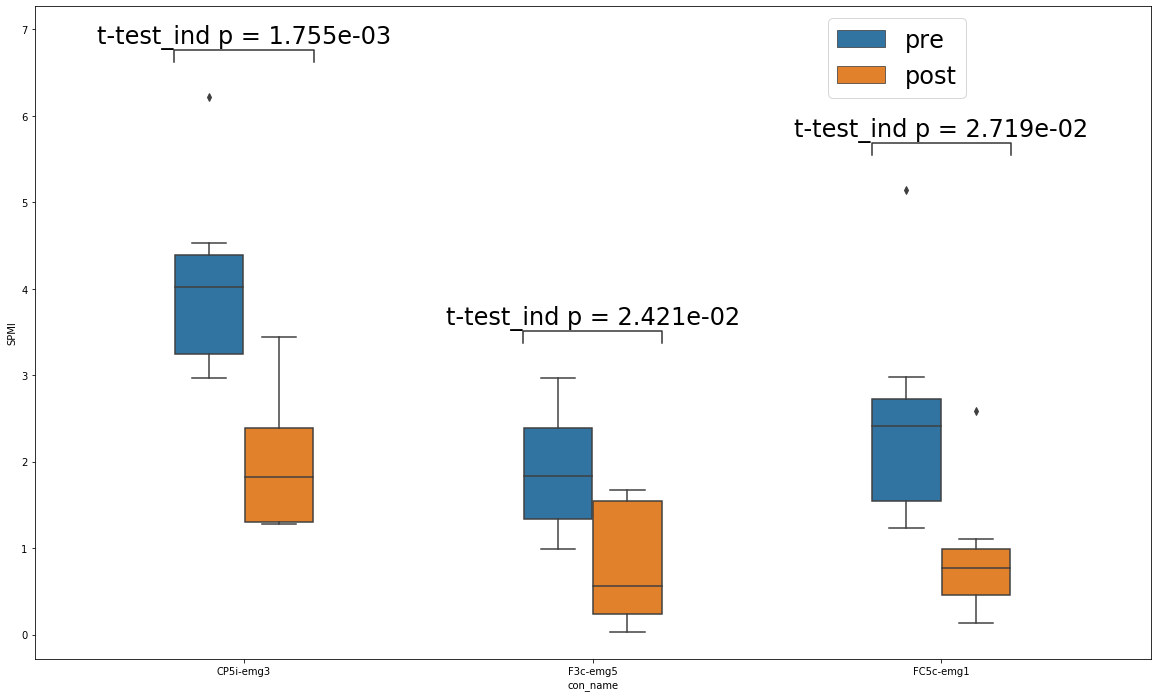

In [495]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
# df = None
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
dfs2concate = []
con_sig_name=[]
fig,ax = plt.subplots(figsize=(20, 12))
for ch1_idx in range(SPMI_withoutD_z.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_withoutD_z.shape[1]):
        if sig_cons_mask[ch1_idx][ch2_idx] != 0: # significant diff
            ch1_name = chs_list_image[ch1_idx]
            ch2_name = chs_list_image[ch2_idx]
            con_name = [ch1_name +'-'+ ch2_name]*(len(stroke_subj)+len(stroke_subj))
            con_sig_name.append(con_name[0])
            SPMI4df = np.concatenate((SPMI_withoutD_z_preTMS[:,ch1_idx,ch2_idx],SPMI_withoutD_z_postTMS[:,ch1_idx,ch2_idx]))
            order = np.concatenate((np.array(['pre']*len(stroke_subj)),np.array(['post']*len(stroke_subj))))
            data = {'con_name':con_name,'SPMI':SPMI4df,'order':order}
            dfs2concate.append(pd.DataFrame(data, columns = ['con_name','SPMI','order']))

df = pd.concat(dfs2concate)
            
x = 'con_name'
y = 'SPMI'
hue = 'order'
ax = sns.boxplot(data=df, x=x, y=y, hue=hue,ax=ax,width = 0.4)
add_stat_annotation(ax,data=df, x=x, y=y, 
            box_pairs=[((con_sig_name[i],"pre"),(con_sig_name[i],"post")) 
                       for i in range(int(len(df['con_name'])/len(stroke_subj)/2))],
            hue=hue,test='t-test_ind',text_format='full',fontsize=24,verbose=1)
 
plt.legend(loc='upper left', bbox_to_anchor = (0.7,1),prop={'size': 24})
con_diff_prePostTMS_bp_fName = os.path.join(global_results_dir,'prePostTMS_sigConnection_bp.eps')
# plt.savefig(con_diff_prePostTMS_bp_fName)
# plt.cla()


# End of processing
